# Part B:Reinforcement Learning for Pendulum Control

DAAA/FT/2A/03

- Oak Khant Soe
  - P2340809

  
- Julio
  - P2317384

# Reinforcement Learning for Pendulum Control

## Background Information

OpenAI Gym is a toolkit for developing and comparing reinforcement learning (RL) algorithms. It provides a standardized interface for various environments, making it easier to design, train, and evaluate RL models.

- Gym offers a wide range of environments, from simple tasks to complex simulations, enabling consistent benchmarking and experimentation.
- The Pendulum-v0 environment in Gym simulates a pendulum that starts in a random position and must be swung up and balanced. This environment is commonly used to test continuous action space algorithms, as it requires learning precise control strategies.

## Objectives

The objective of this notebook is to build a reinforcement learning network that is able to solve the pendulum problem of the OpenAI Gym. The reinforcement learning network in this case would be based on a DQN architecture - actor network, critic network, replay, and Q-function.

----

# Set up and Importations

In [3]:
import gym
import tensorflow as tf
import matplotlib

%matplotlib inline

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.losses import *

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
from collections import deque, namedtuple
from IPython.display import clear_output, display, HTML
from PIL import Image

# Checking if GPU is available
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

### Creating Gym Enviroment

In [6]:
env_name = "Pendulum-v0"
env = gym.make(env_name)

print(f"Input: {env.observation_space}")
print(f"Output: {env.action_space}")

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Input: Box(-8.0, 8.0, (3,), float32)
Output: Box(-2.0, 2.0, (1,), float32)
Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


# Parameters and modifications

In [7]:
# Parameters

EPOCHS = 500
batch_size = 64
gamma = 0.99
tau = 0.005
alpha = 0.6
beta = 0.4

save_threshold = -100

# Define a list of colors that complement a blue and white background
colors = ['orange', 'pink', 'purple', 'red', 'darkgreen']

# Select a random color from the list
selected_color = random.choice(colors)

# Explanation of Approaches in Reinforcement Learning

Reinforcement learning aims to train agents to make decisions by interacting with an environment to maximize some notion of cumulative reward. Various reinforcement learning (RL) algorithms have been developed to handle different types of action spaces and tasks:

- ### Deep Q-Network (DQN)

  - **Approach:** DQN is a value-based RL algorithm that approximates the Q-value function using a neural network to estimate the expected return of taking specific actions in given states.

  - **Limitation:** It is designed for discrete action spaces, making it unsuitable for environments like Pendulum-v0 with continuous actions.

- ### Normalized Advantage Functions (NAF)

  - **Approach:** NAF extends DQN to continuous action spaces by decomposing the Q-value function into a value function and a quadratic advantage function.

  - **Advantages:** This approach allows the agent to learn precise control strategies in continuous action environments, making it suitable for tasks like balancing the pendulum.

- ### Deep Deterministic Policy Gradient (DDPG)

  - **Approach:** DDPG is an actor-critic algorithm where the actor network determines the continuous actions to take, and the critic network evaluates these actions. It uses deterministic policies, meaning the actor outputs a specific action for each state.

  - **Advantages:** DDPG excels in continuous action spaces by learning both the policy (actor) and the value function (critic), enabling efficient learning and control in environments like Pendulum-v0.

- ### Twin Delayed DDPG (TD3)

  - **Approach:** TD3 builds upon DDPG by addressing its limitations, such as overestimation bias in Q-value estimates. It introduces two critic networks to provide more accurate value estimates and delays the policy updates to stabilize training.

  - **Advantages:** TD3 improves the stability and performance of the learning process in continuous action spaces, making it highly effective for complex control tasks like those found in Pendulum-v0.


---
---

# Application of RL Techniques in Pendulum-v0 Environment

Applying reinforcement learning (RL) to the Pendulum-v0 environment involves training an agent to swing up and balance a pendulum starting from a random position. The continuous action space of this environment necessitates the agent to learn fine-grained control strategies to achieve and maintain the desired state.

- ## Deep Q-Network (DQN)

  - **Rationale:** While DQN is effective for discrete actions, it is not suitable for continuous action spaces like Pendulum-v0 due to its inability to handle infinite possible actions. Its fixed action values limit its applicability in scenarios requiring nuanced control. So Turn continuous action environment into discerete environment.

- ## Normalized Advantage Functions (NAF)

  - **Rationale:** NAF adapts the DQN approach for continuous actions by parameterizing the Q-value function in a manner that accommodates continuous control. This adaptation makes it more suitable for environments like Pendulum-v0, where precise control is essential.

- ## Using Deep Deterministic Policy Gradient (DDPG)

  - **Rationale:** DDPG is designed specifically for continuous action spaces, employing an actor-critic architecture to learn both the policy and value functions simultaneously. This dual-learning mechanism enables the agent to effectively learn precise control strategies necessary for balancing the pendulum, overcoming the limitations of DQN.

- ## Using Twin Delayed DDPG (TD3)

  - **Rationale:** TD3 enhances DDPG by introducing twin critics and delayed policy updates to mitigate overestimation bias and stabilize training. These improvements result in enhanced performance and robustness in continuous action environments like Pendulum-v0, making it particularly effective for complex control tasks.


---

## Model and Network Creations : QNetwork Class
- The QNetwork class implements a neural network for Q-value estimation in Deep Q-Learning.

In [8]:
class QNetwork(tf.keras.Model):
    def __init__(self, state_dim, action_size, tau=0.001):
        super(QNetwork, self).__init__()
        self.state_dim = state_dim
        self.action_size = action_size
        self.tau = tau

        # Build the model
        self.q_state_local = self.build_model("local")
        self.q_state_target = self.build_model("target")
        
        # Define the optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

        self.q_state_local.compile(optimizer=self.optimizer, loss=tf.keras.losses.Huber())
        self.q_state_target.compile(optimizer=self.optimizer, loss=tf.keras.losses.Huber())

##--##
    def build_model(self, scope):
    #     model =Sequential(name=scope)
    #     model.add(Input(shape=self.state_dim))
    #     model.add(Dense(128, activation='relu'))
    #     model.add(BatchNormalization())
    #     model.add(Dense(128, activation='relu'))
    #     model.add(Dense(self.action_size, activation=None))
    #     return model

        model_input = Input(shape=self.state_dim)
        x = Lambda(lambda layer: layer / 255)(model_input)  # normalize by 255

        x = Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.))(x)
        x = BatchNormalization()(x)
        x = Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.))(x)

        # Split into value and advantage streams
        val_stream, adv_stream = Lambda(lambda w: tf.split(w, 2, 1))(x)  # custom splitting layer

        val_stream = Flatten()(val_stream)
        val = Dense(1, kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.))(val_stream)

        adv_stream = Flatten()(adv_stream)
        adv = Dense(self.action_size, kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.))(adv_stream)

        # Combine streams into Q-Values
        reduce_mean = Lambda(lambda w: tf.reduce_mean(w, axis=1, keepdims=True))  # custom layer for reduce mean

        q_vals = Add()([val, Subtract()([adv, reduce_mean(adv)])])

        # Build model
        model = Model(model_input, q_vals)
        
        return model
    
##--##

    def call(self, state, action=None, q_target=None, importance=None):
        q_state_local = self.q_state_local(state)
        q_state_action = tf.reduce_sum(tf.multiply(q_state_local, tf.one_hot(action, depth=self.action_size)), axis=1)
        return q_state_action, q_state_local

    @tf.function
    def update_model(self, state, action, q_target, importance):
        with tf.GradientTape() as tape:
            q_state_action, _ = self.call(state, action)
            error = q_state_action - q_target
            loss = tf.reduce_mean(tf.square(error) * importance)
        grads = tape.gradient(loss, self.q_state_local.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.q_state_local.trainable_variables))
        self.update_target_network()
        return tf.abs(error)

    def update_target_network(self):
        for target_var, local_var in zip(self.q_state_target.variables, self.q_state_local.variables):
            target_var.assign(target_var * (1 - self.tau) + local_var * self.tau)

    def get_q_state(self, state, use_target=False):
        q_state_model = self.q_state_target if use_target else self.q_state_local
        return q_state_model(state)

### Key Features:
- Implements a dueling DQN architecture with separate value and advantage streams.
Uses batch normalization and ReLU activation for improved training stability.
Includes methods for model updates and target network synchronization.

##  DQN_PrioritizedReplayBuffer Class
- This class implements a prioritized experience replay buffer for more efficient learning.

In [9]:
class DQN_PrioritizedReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        self.priorities = deque(maxlen=maxlen)
        
    def add(self, experience):
    # Ensure experience is a tuple of fixed-size elements
        if len(experience) != 5:
            raise ValueError(f"Invalid experience length: {len(experience)}")
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))

        
    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities) ** priority_scale
        sample_probabilities = scaled_priorities / sum(scaled_priorities)
        return sample_probabilities
    
    def get_importance(self, probabilities):
        importance = 1/len(self.buffer) * 1/probabilities
        importance_normalized = importance / max(importance)
        return importance_normalized
        
    def sample(self, batch_size, priority_scale=1.0):
        sample_size = min(len(self.buffer), batch_size)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k=sample_size, weights=sample_probs)
    
        # Debug: Print shapes of experiences
        samples = [self.buffer[i] for i in sample_indices]
        for i, sample in enumerate(samples):
            print(f"Sample {i}: {sample}, Shape: {[np.shape(x) if hasattr(x, 'shape') else 'N/A' for x in sample]}")
    
        # Ensure all elements in self.buffer have the same shape
        try:
            samples = np.array(samples, dtype=object)
        except Exception as e:
            print(f"Error converting to array: {e}")
    
        importance = self.get_importance(sample_probs[sample_indices])
        return map(list, zip(*samples)), importance, sample_indices

    def set_priorities(self, indices, errors, offset=0.1):
        print(f"Indices: {indices}")  # Debug print
        print(f"Errors: {errors}")    # Debug print

        if indices.size == 0:
            print("Warning: Indices are empty, skipping priority update")
            return
        
        if isinstance(errors, np.ndarray) and errors.ndim > 1:
            errors = errors.flatten()

        for i, e in zip(indices, errors):
            priority = float(abs(e) + offset)  # Ensure priority is a scalar
            self.priorities[i] = priority

## Key Features:
- Stores experiences with associated priorities.
- Implements importance sampling for unbiased updates.
- Provides methods for adding experiences, sampling, and updating priorities.

## DoubleDQNAgent Class
- The DoubleDQNAgent class implements the Double DQN algorithm with prioritized experience replay.

In [10]:
class DoubleDQNAgent:
    def __init__(self, env, tau=0.001):
        self.state_dim = env.observation_space.shape
        self.action_size = env.action_space.n
        self.q_network = QNetwork(self.state_dim, self.action_size)
        self.q_target_network = QNetwork(self.state_dim, self.action_size)
        self.replay_buffer = DQN_PrioritizedReplayBuffer(maxlen=100000)
        self.gamma = 0.97
        self.eps = 1.0
        self.eps_min = 0.1
        self.eps_decay = 0.99
        self.tau = tau
        self.update_target_network()

    def get_action(self, state):
        state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
        q_state = self.q_network.get_q_state(state_tensor)
        action_greedy = np.argmax(q_state)

        if np.random.rand() < self.eps:
            action = np.random.randint(self.action_size)
        else:
            action = action_greedy

        return action

    def get_env_action(self, action):
        return action

    def train(self, state, action, next_state, reward, done, a=0.0):
        self.replay_buffer.add((state, action, next_state, reward, done))
        (states, actions, next_states, rewards, dones), importance, indices = self.replay_buffer.sample(50, priority_scale=a)

        # Flatten states and next_states if necessary
        states = np.array([np.array(s).flatten() if isinstance(s, np.ndarray) and s.ndim > 1 else np.array(s) for s in states], dtype=np.float32)
        next_states = np.array([np.array(ns).flatten() if isinstance(ns, np.ndarray) and ns.ndim > 1 else np.array(ns) for ns in next_states], dtype=np.float32)
        
        actions = np.array(actions, dtype=np.int32)
        next_states = np.array(next_states, dtype=np.float32)
        rewards = np.array(rewards, dtype=np.float32)
        dones = np.array(dones, dtype=np.float32)

        next_actions = np.argmax(self.q_network.get_q_state(tf.convert_to_tensor(next_states, dtype=tf.float32)).numpy(), axis=1)
        q_next_states = self.q_target_network.get_q_state(tf.convert_to_tensor(next_states, dtype=tf.float32))

        dones_tensor = tf.convert_to_tensor(dones, dtype=tf.bool)
        zeros = tf.zeros([self.action_size], dtype=q_next_states.dtype)
        indices_done = tf.where(dones_tensor)
        q_next_states = tf.tensor_scatter_nd_update(q_next_states, indices_done, tf.repeat(tf.expand_dims(zeros, axis=0), tf.shape(indices_done)[0], axis=0))
        q_next_states_next_actions = tf.gather(q_next_states, next_actions, batch_dims=1)
        q_targets = rewards + self.gamma * q_next_states_next_actions

        errors = self.q_network.update_model(tf.convert_to_tensor(states, dtype=tf.float32),
                                             tf.convert_to_tensor(actions, dtype=tf.int32),
                                             tf.convert_to_tensor(q_targets, dtype=tf.float32),
                                             tf.convert_to_tensor(importance**(1-self.eps), dtype=tf.float32))

        errors_np = errors.numpy() if errors is not None else None
        indices_np = np.asarray(indices)

        if indices_np.size > 0 and errors_np is not None:
            self.replay_buffer.set_priorities(indices_np, errors_np)

        if done:
            self.eps = max(self.eps_min, self.eps * self.eps_decay)

    def update_target_network(self):
        for target_var, local_var in zip(self.q_target_network.variables, self.q_network.variables):
            target_var.assign(target_var * (1 - self.tau) + local_var * self.tau)

    def save_models(self, filepath):
        self.q_network.save_weights(filepath + '_q_model_weights.h5')
        with open(filepath + '_q_model_architecture.json', 'w') as f:
            f.write(self.q_network.to_json())
        
        self.q_target_network.save_weights(filepath + '_q_target_model_weights.h5')
        with open(filepath + '_q_target_model_architecture.json', 'w') as f:
            f.write(self.q_target_network.to_json())

### Key Features:
- Implements epsilon-greedy exploration strategy.
- Uses Double DQN for reduced overestimation bias.
- Includes prioritized experience replay for efficient learning.

## DiscretizedDQNAgent Class
- This class extends DoubleDQNAgent to handle continuous action spaces by discretization.

In [11]:
class DiscretizedDQNAgent(DoubleDQNAgent):
    def __init__(self, env, n_actions=10):
        self.is_discrete = type(env.action_space) == gym.spaces.discrete.Discrete
        if not self.is_discrete:
            env.action_space.n = n_actions
            self.actions = np.linspace(env.action_space.low, env.action_space.high, n_actions)
        super().__init__(env)
        
    def get_env_action(self, action):
        if not self.is_discrete:
            action = [self.actions[action]]
        return action

### Key Features:
- Adapts the DQN algorithm for continuous action spaces.
- Discretizes the action space into a fixed number of actions.

# Agent Initialization

In [12]:
dqn_agent = DiscretizedDQNAgent(env)
dqn_ep_reward_list = []
dqn_avg_reward_list = []

if not os.path.isdir('save_network/DQN'):
        os.makedirs('save_network/DQN')

To initialize the DQN agent and creates necessary directories for saving models.

# Training Loop

In [13]:
%%time

saved_model_counter = 0

tf.keras.backend.clear_session()
K.clear_session()

txt = open("save_network/DQN/saved_networks.txt", "w")

for eps in range(EPOCHS):
    start_time = time.time()
    state = env.reset()
    episode_reward = 0
    done = False

    while not done:
        if eps%10 == 0:
            env.render()  #!Debug

        action = dqn_agent.get_action(state)
        next_state, reward, done, info = env.step(dqn_agent.get_env_action(action))
        dqn_agent.train(state, action, next_state, reward, done, a=0.7)
        episode_reward += reward
        state = next_state

    dqn_ep_reward_list.append(episode_reward)
    avg_reward = np.mean(dqn_ep_reward_list[-50:])
    end_time = time.time()
    epoch_duration = end_time - start_time
    
    dqn_avg_reward_list.append(avg_reward)

    clear_output(wait=True)

    print(f"Episode * {eps} * Reward is ==> {episode_reward}, Time Taken: {epoch_duration:.2f}s")
    print(f"Episode * {eps} * Avg Reward is ==> {avg_reward}, Time Taken: {epoch_duration:.2f}s")
        
    if eps > 50 and avg_reward >= -200:
        print(f"##### Reach -200 AT {eps} #####")
        dqn_agent.save_models(f'save_network/DQN/{eps}')
        txt.write(f'network {saved_model_counter} saved at episode {eps} with avg reward {avg_reward} \n')
        txt.write(f'Model saved after {epoch_duration:.2f} seconds\n')
        txt.write('\n')
        saved_model_counter += 1
        
    if eps % 100 == 0:
        dqn_agent.save_models(f'save_network/DQN/{eps}')
        txt.write(f'network {saved_model_counter} saved at episode {eps} with avg reward {avg_reward} \n')
        txt.write(f'Model saved after {epoch_duration:.2f} seconds\n')
        txt.write('\n')
        saved_model_counter += 1

txt.close()

print("Finished training!")
env.close()

Episode * 98 * Reward is ==> [-1198.5266], Time Taken: 9.42s
Episode * 98 * Avg Reward is ==> -1312.6209716796875, Time Taken: 9.42s
Sample 0: (array([[-0.83002806],
       [-0.5577217 ],
       [-1.3255403 ]], dtype=float32), 7, array([[-0.8713839],
       [-0.4906018],
       [-1.5771649]], dtype=float32), array([-6.679209], dtype=float32), False), Shape: [(3, 1), 'N/A', (3, 1), (1,), 'N/A']
Sample 1: (array([[-0.9512736],
       [-0.308348 ],
       [-6.3886924]], dtype=float32), 9, array([[-9.9999678e-01],
       [ 2.5416904e-03],
       [-6.3199534e+00]], dtype=float32), array([-12.083897], dtype=float32), False), Shape: [(3, 1), 'N/A', (3, 1), (1,), 'N/A']
Sample 2: (array([[-0.35097402],
       [ 0.9363852 ],
       [ 2.3207257 ]], dtype=float32), 0, array([[-0.47482216],
       [ 0.8800818 ],
       [ 2.7230146 ]], dtype=float32), array([-4.2651896], dtype=float32), False), Shape: [(3, 1), (), (3, 1), (1,), 'N/A']
Sample 3: (array([[-0.99649227],
       [ 0.08368478],
       [-

### Key Features:
- Implements the main training loop for the DQN agent.
- Tracks episode rewards and periodically saves the model.
- Renders the environment every 10 episodes for visualization.

# Visualise our final results

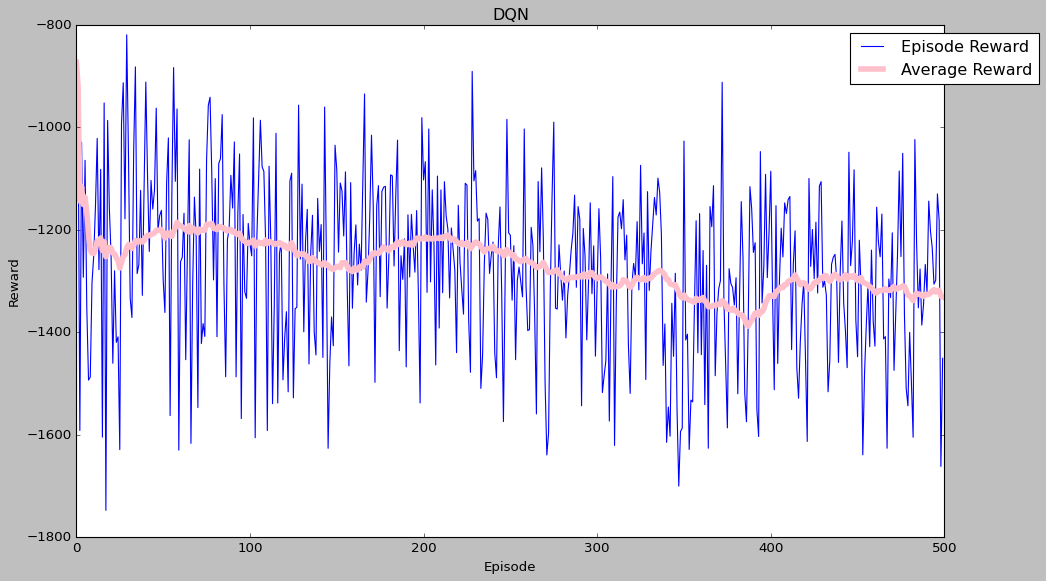

In [222]:
# Plotting training graph
with plt.style.context('classic'):
    plt.figure(figsize=(14, 8))
    plt.plot(dqn_ep_reward_list, label='Episode Reward')
    plt.plot(dqn_avg_reward_list, linewidth=5, color=selected_color, label='Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title("DQN")
    plt.legend(loc='upper center', bbox_to_anchor=(1, 1))

    plt.savefig('save_network/DQN/Train_Learning_Curve.png')
    plt.show()

---

## Replay Buffer and Experience Replay
  `A buffer (temporary memory) of observations, rewards, and subsequent observations. The buffer is used to then train the Deep Learning model.`

The purpose of Experience Replay is to store past experiences and then using a random subset of these experiences to update the Q-network, rather than using just the single recent experience.

A replay buffer contains a collection of experience (State, Action, Reward, New State). Normally, a replay buffer is store as a queue, where new buffer is added to the end so that it pushes the oldest experience out of it.

## Simple Replay Buffer

In [9]:
# The ReplayBuffer class is used to store experiences in a buffer of size N. 
# The buffer is used to sample a batch of experiences from the buffer to train the agent.

class SimpleReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", ["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = tf.convert_to_tensor([e.state for e in experiences], dtype=tf.float32)
        actions = tf.convert_to_tensor([e.action for e in experiences], dtype=tf.float32)
        rewards = tf.convert_to_tensor([e.reward for e in experiences], dtype=tf.float32)
        next_states = tf.convert_to_tensor([e.next_state for e in experiences], dtype=tf.float32)
        dones = tf.convert_to_tensor([e.done for e in experiences], dtype=tf.float32)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

## The SimpleReplayBuffer class implements a basic replay buffer:
- Stores experiences as named tuples
- Allows adding new experiences
- Provides random sampling of experiences
- Converts sampled experiences to TensorFlow tensors

## Prioritized Replay Buffer

In [10]:
class PrioritizedReplayBuffer:
    def __init__(self, buffer_size, batch_size, alpha=0.6):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.alpha = alpha
        self.memory = []
        self.priorities = []
        self.position = 0

    def add(self, state, action, reward, next_state, done):
        max_priority = max(self.priorities, default=1.0)
        experience = (state, action, reward, next_state, done)
        if len(self.memory) < self.buffer_size:
            self.memory.append(experience)
            self.priorities.append(max_priority)
        else:
            self.memory[self.position] = experience
            self.priorities[self.position] = max_priority
            self.position = (self.position + 1) % self.buffer_size

    def sample(self, beta=0.4):
        priorities = np.array(self.priorities)
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()

        indices = np.random.choice(len(self.memory), self.batch_size, p=probabilities)
        experiences = [self.memory[i] for i in indices]

        total = len(self.memory)
        weights = (total * probabilities[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)

        states, actions, rewards, next_states, dones = zip(*experiences)

        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)

        return (states, actions, rewards, next_states, dones, indices, weights)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority

    def __len__(self):
        return len(self.memory)

## The PrioritizedReplayBuffer class enhances the simple replay buffer:
- Assigns priorities to experiences
- Samples experiences based on their priorities
- Implements importance sampling to correct for bias
- Allows updating priorities based on TD errors

---
---

## Noise Generation for Exporation
Introducing noise into the action selection process can help with exploration by encouraging the agent to try out different actions even if they seem suboptimal based on current knowledge. 

This randomness can lead to discovering better strategies that were not apparent under deterministic action selections.

## Gaussian Noise

In [11]:
class GaussianNoise:    #Gaussian Noise is stateless and good for independent random perturbations.
    def __init__(self, size, mu=0, sigma=1):
        """
        Initialize the Gaussian noise generator.

        Parameters:
        - size: The number of dimensions for the generated noise.
        - mu: Mean of the Gaussian distribution. Default is 0.
        - sigma: Standard deviation of the Gaussian distribution. Default is 1.
        """
        self.mu = mu
        self.sigma = sigma
        self.size = size

    def reset(self):
        """Reset the internal state of the Gaussian noise generator."""
        pass  # No need to reset for Gaussian noise as it's stateless.

    def __call__(self):
        """
        Generate a new sample from the Gaussian distribution.

        Returns:
            np.ndarray: A sample from the Gaussian distribution with shape (size,).
        """
        return np.random.normal(self.mu, self.sigma, self.size)

`The GaussianNoise class generates samples from a Gaussian distribution, which can be used to add independent random perturbations to actions. This form of noise is stateless, meaning it does not depend on the current state of the environment or the agent's past actions.`

In [12]:
class OUActionNoise:    #OU Noise is stateful and good for correlated noise, often used in continuous control tasks for better exploration.
    def __init__(self, size, mu=0, theta=0.15, sigma=0.2, dt=1e-2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.dt = dt
        self.size = size
        self.reset()

    def reset(self):
        self.state = np.ones(self.size) * self.mu

    def __call__(self):
        x = self.state
        dx = self.theta * (self.mu - x) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.state = x + dx
        return self.state

`The OUActionNoise class implements Ornstein-Uhlenbeck noise, which is a type of correlated noise. Unlike Gaussian noise, OU noise is stateful; it depends on the current state of the agent and changes over time according to a differential equation. This form of noise is particularly suited for continuous control tasks where actions are vectors in high-dimensional spaces. `

----

## Normalized Advantage Function (NAF) reinforcement learning model

    In this model, the terms "V model," "mu model," and "L model" refer to specific components of the NAF architecture that work together to handle continuous action spaces efficiently. 

- *V Model* (State Value Function)

    -   Description: The V model represents the state value function, which estimates the expected return (cumulative future rewards) for being in a particular state under a given policy. It helps in understanding the intrinsic value of being in a certain state without considering any actions taken from that state.
    -   Role in NAF: In NAF, the V model is part of the Q-value calculation, providing a baseline against which the advantage function (represented by the L model) is normalized. This normalization process helps in stabilizing the learning process, especially in environments with high variance in rewards.

-   *Mu Model* (Policy Function)

    -   Description: The mu model corresponds to the policy function, which predicts the optimal action to take in a given state. Unlike traditional Q-learning methods, NAF separates the policy prediction into a separate model, allowing for more flexible and efficient learning in continuous action spaces.
    -   Role in NAF: The mu model outputs the mean action (best guess for the action) for a given state. This action is then used in conjunction with the L model to compute the advantage function, which measures how much better an action is compared to the average action predicted by the policy.

-   *L Model* (Advantage Function)

    -   Description: The L model calculates the advantage function, which quantifies the difference between the expected return of taking a specific action versus taking the average action predicted by the policy. The advantage function is crucial for handling continuous action spaces because it allows the agent to focus on improving actions that are significantly better than average.
    -   Role in NAF: The L model computes the advantage of taking a specific action over the mean action suggested by the mu model. This advantage is then normalized and combined with the state value function (V model) to calculate the final Q-value. The normalization process ensures that the advantage function remains bounded, which aids in stabilizing the learning process.
  
  ----
  ----

## Model Components
### V Model (State Value Function)
### L Model (Advantage Function)
### Mu Model (Policy Function)

In [227]:
def create_v_model(env):
    state_input = Input(shape=(env.observation_space.shape[0],), name='state_input')
    v_layer = Dense(128, activation='relu')(state_input)
    v_layer = BatchNormalization(momentum=0.9)(v_layer)
    v_layer = Dense(128, activation='relu')(v_layer)
    v_layer = BatchNormalization(momentum=0.9)(v_layer)
    v_output = Dense(1)(v_layer)
    v_model = Model(inputs=state_input, outputs=v_output, name="v_model")
    return v_model

def create_l_model(env):
    state_input = Input(shape=(env.observation_space.shape[0],), name='state_input')
    l_layer = Dense(128, activation='relu')(state_input)
    l_layer = BatchNormalization(momentum=0.9)(l_layer)
    l_layer = Dense(128, activation='relu')(l_layer)
    l_layer = BatchNormalization(momentum=0.9)(l_layer)
    l_output = Dense(int(env.action_space.shape[0] * (env.action_space.shape[0]+1)/2))(l_layer)
    l_model = Model(inputs=state_input, outputs=l_output, name="l_model")
    return l_model

def create_mu_model(env):
    state_input = Input(shape=(env.observation_space.shape[0],), name='state_input')
    mu_layer = Dense(128, activation='relu')(state_input)
    mu_layer = BatchNormalization(momentum=0.9)(mu_layer)
    mu_layer = Dense(128, activation='relu')(mu_layer)
    mu_layer = BatchNormalization(momentum=0.9)(mu_layer)
    mu_output = Dense(env.action_space.shape[0], activation='tanh')(mu_layer)

    mu_model = Model(inputs=state_input, outputs=mu_output, name="mu_model")
    return mu_model

### V model
- Purpose: Estimates the expected return for being in a particular state.
- Architecture: Two dense layers with ReLU activation and batch normalization, followed by a single output neuron.
- Role: Provides a baseline for the advantage function, stabilizing learning in environments with high reward variance.
### L model
- Purpose: Calculates the advantage of taking a specific action over the mean action.
- Architecture: Similar to V model, but with an output size based on the action space dimensions.
- Role: Helps focus on improving actions that are significantly better than average.
### Mu Model (Policy Function)
- Purpose: Predicts the optimal action for a given state.
- Architecture: Similar to V and L models, but with a tanh activation in the output layer to bound actions.
- Role: Provides the mean action, which is used in conjunction with the L model to compute the advantage.

---

## NAF DQN Agent

In [228]:
class NAFDQNAgent:
    def __init__(self, env, v_model, l_model, mu_model, buffer_size, batch_size, gamma=0.99, tau=0.005, upper_bound=2.0):
        self.env = env
        self.gamma = gamma
        self.tau = tau
        self.upper_bound = upper_bound

        self.v_model = v_model
        self.l_model = l_model
        self.mu_model = mu_model
        
        self.v_target = tf.keras.models.clone_model(v_model)
        self.l_target = tf.keras.models.clone_model(l_model)
        self.mu_target = tf.keras.models.clone_model(mu_model)

        self.update_target_models(tau=1.0)
        self.replay_buffer = SimpleReplayBuffer(buffer_size, batch_size)
        self.noise = GaussianNoise(env.action_space.shape[0])

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    def update_target_models(self, tau=None):
        if tau is None:
            tau = self.tau

        for target_model, model in zip([self.v_target, self.l_target, self.mu_target], [self.v_model, self.l_model, self.mu_model]):
            new_weights = model.get_weights()
            target_weights = target_model.get_weights()
            updated_weights = [tau * nw + (1 - tau) * tw for nw, tw in zip(new_weights, target_weights)]
            target_model.set_weights(updated_weights)

    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)

    def act(self, state):
        state = tf.expand_dims(tf.convert_to_tensor(state, dtype=tf.float32), 0)
        action = tf.squeeze(self.mu_model(state))
        noise = self.noise()
        action = action.numpy() + noise
        return np.clip(action, -self.upper_bound, self.upper_bound)

    def train(self):
        if len(self.replay_buffer) < self.replay_buffer.batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample()
        
        with tf.GradientTape() as tape:
            v_values = self.v_model(states)
            l_values = self.l_model(states)
            mu_values = self.mu_model(states)
            
            l_matrix = tf.linalg.band_part(tf.reshape(l_values, [-1, self.env.action_space.shape[0], self.env.action_space.shape[0]]), 0, -1)
            l_matrix = l_matrix + tf.linalg.band_part(tf.transpose(l_matrix, perm=[0, 2, 1]), 0, -1)
            p_matrix = tf.matmul(l_matrix, tf.transpose(l_matrix, perm=[0, 2, 1]))

            q_values = tf.expand_dims(v_values, -1) + 0.5 * tf.matmul(tf.expand_dims(actions - mu_values, 1), tf.matmul(p_matrix, tf.expand_dims(actions - mu_values, -1)))

            next_v_values = self.v_target(next_states)
            target_q_values = rewards + self.gamma * (1.0 - dones) * next_v_values

            loss = tf.reduce_mean(tf.square(target_q_values - q_values))

        grads = tape.gradient(loss, self.v_model.trainable_variables + self.l_model.trainable_variables + self.mu_model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.v_model.trainable_variables + self.l_model.trainable_variables + self.mu_model.trainable_variables))

        self.update_target_models()

    def save_models(self, filepath):
        self.v_model.save_weights(filepath + '_v_model.h5')
        self.l_model.save_weights(filepath + '_l_model.h5')
        self.mu_model.save_weights(filepath + '_mu_model.h5')

## The NAFDQNAgent class integrates the V, L, and Mu models to create a complete reinforcement learning agent:
- Initializes models and target networks
- Implements experience replay for efficient learning
- Provides methods for action selection, training, and model saving .h5

## Training Loop

In [229]:
# Model and Network Creations

v_model = create_v_model(env)
l_model = create_l_model(env)
mu_model = create_mu_model(env)

agent = NAFDQNAgent(env, v_model=v_model, l_model=l_model, mu_model=mu_model, buffer_size=100000, batch_size=batch_size, gamma=gamma, tau=tau)
ep_reward_list = []
avg_reward_list = []

if not os.path.isdir('save_network/NAF'):
        os.makedirs('save_network/NAF')

In [230]:
%%time

saved_model_counter = 0

tf.keras.backend.clear_session()
K.clear_session()

txt = open("save_network/NAF/saved_networks.txt", "w")

for eps in range(EPOCHS):
    start_time = time.time()
    state = env.reset()
    episode_reward = 0
    done = False

    while not done:
        # env.render()  #!Debug

        action = agent.act(state)
        action = np.clip(action, -env.action_space.high, env.action_space.high)#!change
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.train()
        episode_reward += reward
        state = next_state

    ep_reward_list.append(episode_reward)
    avg_reward = np.mean(ep_reward_list[-50:])
    end_time = time.time()
    epoch_duration = end_time - start_time
    
    avg_reward_list.append(avg_reward)

    clear_output(wait=True)

    print(f"Episode * {eps} * Reward is ==> {episode_reward}, Time Taken: {epoch_duration:.2f}s")
    print(f"Episode * {eps} * Avg Reward is ==> {avg_reward}, Time Taken: {epoch_duration:.2f}s")
        
    if eps > 50 and avg_reward >= save_threshold:
        agent.save_models(f"save_network/NAF/model_{saved_model_counter}")
        txt.write(f"Save {saved_model_counter} - Episode {eps}/{EPOCHS}, Score: {episode_reward}, Avg Reward: {avg_reward}\n")
        saved_model_counter += 1

txt.close()

print("Finished training!")
env.close()

Episode * 499 * Reward is ==> -1253.28740153339, Time Taken: 22.39s
Episode * 499 * Avg Reward is ==> -1231.0081308150404, Time Taken: 22.39s
Finished training!
CPU times: total: 50min 45s
Wall time: 2h 58min 51s


## The training loop:
Initializes the environment and agent
For each episode:
Resets the environment
Repeatedly:
Selects actions using the agent
Executes actions in the environment
Stores experiences and trains the agent
Logs performance and saves models if criteria are met
Plots the learning curve after training
- This implementation of NAF demonstrates an advanced approach to reinforcement learning in continuous action spaces, combining the strengths of DQN with the ability to handle continuous actions efficiently.

# Visualise Results

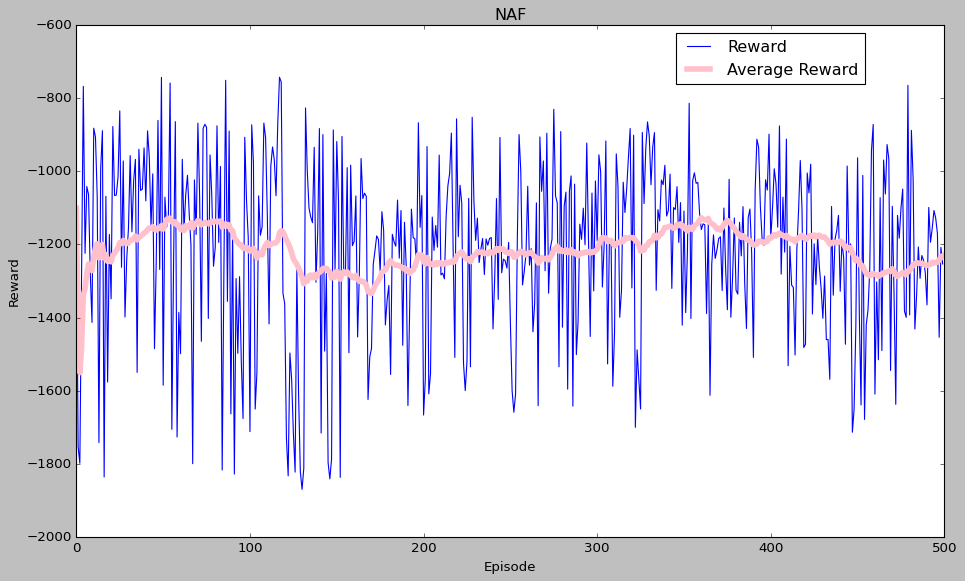

In [231]:
# Plotting training graph
with plt.style.context('classic'):
    plt.figure(figsize=(14, 8))
    plt.plot(ep_reward_list)
    plt.plot(avg_reward_list, linewidth=5, color=selected_color)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title("NAF")
    plt.legend(['Reward', 'Average Reward'], loc='upper center', bbox_to_anchor=(0.8, 1))

    plt.savefig('save_network/NAF/Train Learning Curve.png')

    plt.show()

---
---

# NAF Model Improvement 
### The improved NAF model incorporates several advanced techniques to enhance performance:
- Prioritized Experience Replay
- Ornstein-Uhlenbeck Action Noise
- Ensemble Training
### Model Architecture
The model consists of three main components:
- V-Model (Value Function)
- L-Model (Advantage Function)
- Mu-Model (Policy Function)
### Each model uses a similar architecture:
- Two dense layers with 64 units and ReLU activation
- Batch normalization after each dense layer
- Output layer specific to each model's purpose

---
---

## Model Architecture
The model consists of three main components:
- V-Model (Value Function)
- L-Model (Advantage Function)
- Mu-Model (Policy Function)
## Each model uses a similar architecture:
- Two dense layers with 64 units and ReLU activation
- Batch normalization after each dense layer
- Output layer specific to each model's purpose

In [13]:
def mod_create_v_model(env):
    state_input = Input(shape=(env.observation_space.shape[0],), name='state_input')
    x = Dense(64, activation='relu')(state_input)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    v_output = Dense(1)(x)

    v_model = Model(inputs=state_input, outputs=v_output, name="v_model")
    v_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='mse')
    return v_model

def mod_create_l_model(env):
    state_input = Input(shape=(env.observation_space.shape[0],), name='state_input')
    x = Dense(64, activation='relu')(state_input)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    l_output = Dense(int(env.action_space.shape[0] * (env.action_space.shape[0]+1)/2))(x)

    l_model = Model(inputs=state_input, outputs=l_output, name="l_model")
    return l_model

def mod_create_mu_model(env, upper_bound=2.0):
    last_init = tf.keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)
    state_input = Input(shape=(env.observation_space.shape[0],), name='state_input')
    x = Dense(64, activation='relu')(state_input)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    mu_output = Dense(env.action_space.shape[0], activation='tanh')(x)

    mu_model = Model(inputs=state_input, outputs=mu_output, name="mu_model")
    return mu_model

## ModifiedNAFDQNAgent Class
This class implements the NAF algorithm with the following improvements:
- Prioritized Replay Buffer: Samples important experiences more frequently
- OUActionNoise: Provides temporally correlated exploration noise
- Gradient Clipping: Prevents exploding gradients


In [14]:
class ModifiedNAFDQNAgent:
    def __init__(self, env, v_model, l_model, mu_model, buffer_size, batch_size, gamma=0.99, tau=0.005, upper_bound=2.0, alpha=0.6, beta=0.4):
        self.env = env
        self.gamma = gamma
        self.tau = tau
        self.upper_bound = upper_bound
        self.alpha = alpha
        self.beta = beta

        self.v_model = v_model
        self.l_model = l_model
        self.mu_model = mu_model
        
        self.v_target = tf.keras.models.clone_model(v_model)
        self.l_target = tf.keras.models.clone_model(l_model)
        self.mu_target = tf.keras.models.clone_model(mu_model)

        self.update_target_models(self.tau)
        self.replay_buffer = PrioritizedReplayBuffer(buffer_size, batch_size, alpha)
        self.noise = OUActionNoise(env.action_space.shape[0])

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

    def update_target_models(self, tau=None):
        if tau is None:
            tau = self.tau

        for target_model, model in zip([self.v_target, self.l_target, self.mu_target], [self.v_model, self.l_model, self.mu_model]):
            new_weights = model.get_weights()
            target_weights = target_model.get_weights()
            updated_weights = [tau * nw + (1 - tau) * tw for nw, tw in zip(new_weights, target_weights)]
            target_model.set_weights(updated_weights)

    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)

    def act(self, state):
        state = tf.expand_dims(tf.convert_to_tensor(state, dtype=tf.float32), 0)
        action = tf.squeeze(self.mu_model(state))
        noise = self.noise()
        action = action.numpy() + noise
        return np.clip(action, -self.upper_bound, self.upper_bound)

    def train(self):
        if len(self.replay_buffer) < self.replay_buffer.batch_size:
            return

        states, actions, rewards, next_states, dones, indices, weights = self.replay_buffer.sample(beta=self.beta)
        
        with tf.GradientTape() as tape:
            v_values = self.v_model(states)
            l_values = self.l_model(states)
            mu_values = self.mu_model(states)
            
            l_matrix = tf.linalg.band_part(tf.reshape(l_values, [-1, self.env.action_space.shape[0], self.env.action_space.shape[0]]), 0, -1)
            l_matrix = l_matrix + tf.linalg.band_part(tf.transpose(l_matrix, perm=[0, 2, 1]), 0, -1)
            p_matrix = tf.matmul(l_matrix, tf.transpose(l_matrix, perm=[0, 2, 1]))

            q_values = tf.expand_dims(v_values, -1) + 0.5 * tf.matmul(tf.expand_dims(actions - mu_values, 1), tf.matmul(p_matrix, tf.expand_dims(actions - mu_values, -1)))

            next_v_values = self.v_target(next_states)
            target_q_values = rewards + self.gamma * (1.0 - dones) * next_v_values

            loss = tf.reduce_mean(weights * tf.square(target_q_values - q_values))

        grads = tape.gradient(loss, self.v_model.trainable_variables + self.l_model.trainable_variables + self.mu_model.trainable_variables)
        grads, _ = tf.clip_by_global_norm(grads, 1.0)
        self.optimizer.apply_gradients(zip(grads, self.v_model.trainable_variables + self.l_model.trainable_variables + self.mu_model.trainable_variables))

        self.update_target_models()

    def save_models(self, filepath):
        self.v_model.save(filepath + '_v_model.h5')
        self.l_model.save(filepath + '_l_model.h5')
        self.mu_model.save(filepath + '_mu_model.h5')

## Ensemble Training
- using multiple agents to form an ensemble for improvement

In [234]:
# Multiple Agents
num_agents = 2
naf_agents = []
for _ in range(num_agents):
    mod_v_model = mod_create_v_model(env)
    mod_l_model = mod_create_l_model(env)
    mod_mu_model = mod_create_mu_model(env)
    mod_naf_agent = ModifiedNAFDQNAgent(env, mod_v_model, mod_l_model, mod_mu_model, buffer_size=100000, batch_size=batch_size, gamma=gamma, tau=tau, alpha=alpha, beta=beta)
    naf_agents.append(mod_naf_agent)

modified_ep_reward_list = []
modified_avg_reward_list = []

if not os.path.isdir('save_network/NAF_modified'):
    os.makedirs('save_network/NAF_modified')

def act_ensemble(state):
    actions = []
    for agent in naf_agents:
        action = agent.act(state)
        actions.append(action)
    final_action = np.max(actions, axis=0)
    return np.clip(final_action, -upper_bound, upper_bound)

### This ensemble approach helps to reduce variance and improve overall performance.

## Training Loop
- The training loop incorporates the ensemble approach:

In [240]:
%%time

saved_model_counter = 0

tf.keras.backend.clear_session()
K.clear_session()

txt = open("save_network/NAF_modified/saved_networks.txt", "w")

for eps in range(200):
    start_time = time.time()
    state = env.reset()
    episode_reward = 0
    done = False

    while not done:
        # env.render()

        action = act_ensemble(state)
        next_state, reward, done, _ = env.step(action)
        for agent in naf_agents:
            agent.remember(state, action, reward, next_state, done)
            agent.train()
        episode_reward += reward
        state = next_state

    modified_ep_reward_list.append(episode_reward)
    avg_reward = np.mean(modified_ep_reward_list[-50:])
    end_time = time.time()
    epoch_duration = end_time - start_time
    
    modified_avg_reward_list.append(avg_reward)

    clear_output(wait=True)

    print(f"Episode * {eps} * Reward is ==> {episode_reward}, Time Taken: {epoch_duration:.2f}s")
    print(f"Episode * {eps} * Avg Reward is ==> {avg_reward}, Time Taken: {epoch_duration:.2f}s")
        
    if eps > 50 and avg_reward >= -200:
        for idx, agent in enumerate(naf_agents):
            agent.save_models(f"save_network/NAF_modified/modified_model_{saved_model_counter}_agent_{idx}")
        txt.write(f"Save {saved_model_counter} - Episode {eps}/{EPOCHS}, Average Reward: {avg_reward}\n")
        saved_model_counter += 1

print("Finished training!")

last_agent = naf_agents[-1]

# Save the last agent's models
last_agent.save_models(f"save_network/NAF_modified/modified_model_last_agent.h5")

print("Last model saved successfully.")

env.close()
txt.close()

Episode * 199 * Reward is ==> -1194.6757033307763, Time Taken: 48.90s
Episode * 199 * Avg Reward is ==> -1495.7861748120513, Time Taken: 48.90s
Finished training!
Last model saved successfully.
CPU times: total: 34min 33s
Wall time: 2h 35min 21s


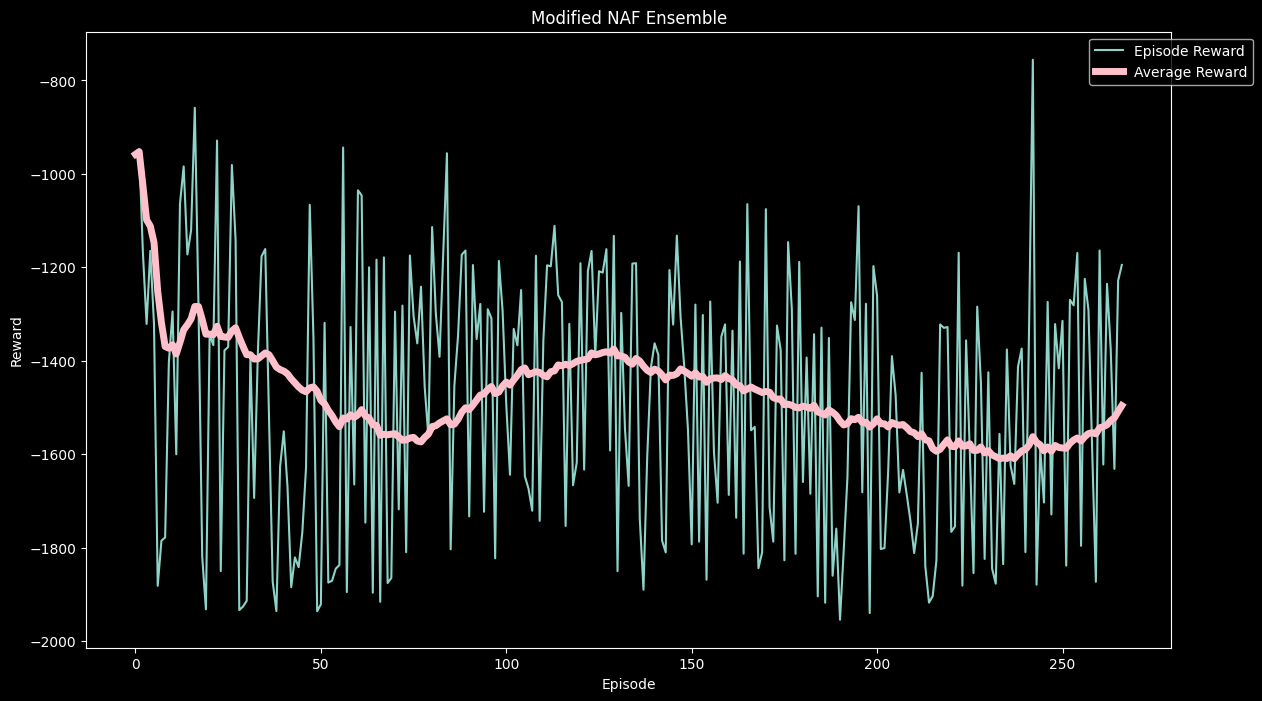

In [241]:
# Plotting training graph
with plt.style.context('dark_background'):
    plt.figure(figsize=(14, 8))
    plt.plot(modified_ep_reward_list, label='Episode Reward')
    plt.plot(modified_avg_reward_list, linewidth=5, color=selected_color, label='Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title("Modified NAF Ensemble")
    plt.legend(loc='upper center', bbox_to_anchor=(1, 1))

    plt.savefig('save_network/NAF_modified/Train_Learning_Curve.png')
    plt.show()

---
---

### Testing Function
- to provide evaluation for the trained agent:

In [11]:
def test_agent(env, agent, folder, episodes=50, video_dir='./video', custom_name='episode'):
    # Ensure the video directory exists
    if not os.path.exists(video_dir):
        os.makedirs(video_dir)
    
    total_rewards = []
    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        frames = []  # Initialize frames list for this episode
        
        while not done:
            env.render()  # Render the environment
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            
            # Capture the current frame and add it to the frames list
            frame = env.render(mode='rgb_array')  # Ensure render mode is set correctly
            frames.append(Image.fromarray(frame))
            
            state = next_state
        
        total_rewards.append(episode_reward)
        clear_output(wait=True)
        print(f"Episode: {episode + 1}, Reward: {episode_reward}")

        speed_up = episodes//10

        # Apply speed-up by selecting every nth frame
        selected_frames = frames[::speed_up]
    
        # Save the GIF for all episodes
        gif_path = os.path.join(video_dir, f"{custom_name}_all_episodes.gif")
        selected_frames[0].save(gif_path, save_all=True, append_images=selected_frames[1:], loop=0, duration=50)
    
    avg_reward = np.mean(total_rewards)
    print(f"Average Reward over {episodes} episodes: {avg_reward}")

    # Plotting the cumulative rewards
    plt.figure(figsize=(10, 5))
    plt.plot(total_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Reward")
    plt.title("Reward Evolution Over Episodes")
    plt.savefig(f'save_network/{folder}/Testing_Learning_Curve.png')
    plt.show()
    
    env.close()

In [15]:
tf.keras.backend.clear_session()
K.clear_session()


mod_v_model = mod_create_v_model(env)
mod_l_model = mod_create_l_model(env)
mod_mu_model = mod_create_mu_model(env, upper_bound)

testing_naf_agent = ModifiedNAFDQNAgent(env, mod_v_model, mod_l_model, mod_mu_model, buffer_size=100000, batch_size=64, gamma=gamma, tau=tau, alpha=alpha, beta=beta)

testing_naf_agent.v_model.load_weights('save_network/NAF_modified/modified_model_last_agent.h5_v_model.h5')
testing_naf_agent.l_model.load_weights('save_network/NAF_modified/modified_model_last_agent.h5_l_model.h5')
testing_naf_agent.mu_model.load_weights('save_network/NAF_modified/modified_model_last_agent.h5_mu_model.h5')

Episode: 20, Reward: -1157.0877110302597
Average Reward over 20 episodes: -1464.8935279009838


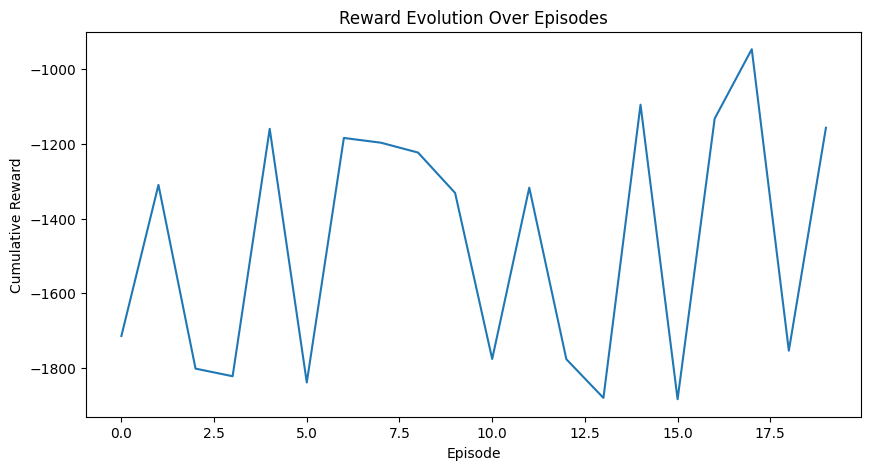

In [17]:
# Run the test
test_agent(env, testing_naf_agent, episodes=20, folder='NAF_modified', custom_name='NAF_modified')

## This function runs the agent for multiple episodes, records performance, and creates visualizations.
## Improvements Over Basic NAF
- Prioritized Experience Replay: Focuses on important experiences, leading to faster and more stable learning.
- OUActionNoise: Provides better exploration in continuous action spaces.
- Ensemble Training: Reduces variance and improves robustness of the learned policy.
- Gradient Clipping: Prevents unstable updates due to large gradients.
- Enhanced Visualization: Includes GIF creation and reward plotting for better analysis.

---
---

## Deep Deterministic Policy Gradient (DDPG) Reinforcement Learning Model

- **Actor Network**
  - *Description*: The Actor network in DDPG determines the best action to take given a current state. It approximates the deterministic policy, directly mapping states to actions. Unlike stochastic policies, where actions are sampled from a probability distribution, the Actor produces deterministic actions.
  - *Role in DDPG*: The Actor explores the environment and exploits known information to maximize rewards. During training, noise can be added to the actions to encourage exploration.

- **Critic Network**
  - *Description*: The Critic network evaluates the quality of actions taken by the Actor. It approximates the Q-function, estimating the expected return of taking a certain action in a given state, following the current policy. The Critic uses Temporal Difference (TD) learning to update its estimates based on observed rewards and next-state values from target networks.
  - *Role in DDPG*: The Critic provides feedback to the Actor by calculating gradients of the expected return with respect to the actions. These gradients guide the Actor's policy updates, refining its decision-making process.

- **Target Networks**
  - *Description*: DDPG employs two sets of target networks—one for the Actor and one for the Critic. These networks are slower-moving copies of the main Actor and Critic networks. They are updated gradually toward the main networks using a soft update mechanism, which averages the parameters of the target and main networks.
  - *Role in DDPG*: Target networks stabilize the learning process by reducing oscillations and divergence. They generate consistent learning targets for Q-value updates, ensuring smoother convergence.

- **Exploration Noise**
  - *Description*: To facilitate exploration in continuous action spaces, DDPG adds noise to the actions proposed by the Actor network during training. This noise encourages the agent to explore different actions beyond the current policy.
  - *Role in DDPG*: Exploration noise allows the agent to discover new strategies, avoid local optima, and explore the environment effectively.


## Deep Deterministic Policy Gradient (DDPG) Model
- DDPG is an actor-critic algorithm designed for continuous action spaces. It combines ideas from DQN (experience replay and target networks) with deterministic policy gradients.
## Key Components:
- Critic Network
- Actor Network
- Target Networks
- Exploration Noise

In [251]:
def create_critic_network(env, model_name='CriticNetwork'):
    state_shape = env.observation_space.shape
    action_shape = env.action_space.shape

    # For state
    state_input = Input(shape=state_shape)
    state_out = Dense(16, activation="relu")(state_input)
    state_out = Dense(64, activation="relu")(state_out)

    # For action
    action_input = Input(shape=action_shape)
    action_out = Dense(16, activation="relu")(action_input)
    action_out = Dense(64, activation="relu")(action_out)

    concat = Concatenate()([state_out, action_out])

    output_layer = Dense(64, activation="relu")(concat)
    output_layer = Dense(16, activation="relu")(output_layer)
    outputs = Dense(1)(output_layer)

    critic_model = Model(inputs=[state_input, action_input], outputs=outputs, name=model_name)
    return critic_model

## ---- ##

def create_actor_network(env, model_name="ActorNetwork"):
    state_shape = env.observation_space.shape
    n_actions = env.action_space.shape[0]
    upper_bound = env.action_space.high[0]

    last_init = tf.keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)
    inputs = Input(shape=state_shape, name='state_input')
    outs = Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(inputs)
    outs = Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(outs)
    outs = Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(outs)
    outputs = Dense(n_actions, activation="tanh", kernel_initializer=last_init)(outs)

    # Scale the output values to the env's requirements
    outputs = outputs * upper_bound

    actor_model = Model(inputs, outputs, name=model_name)
    return actor_model

### Critic Network
- Purpose: Evaluates the quality of state-action pairs.
- Architecture: Separate processing for state and action, then concatenated and further processed.
- Key Feature: Takes both state and action as inputs.

### Actor Network
- Purpose: Determines the best action given a state.
- Architecture: Multiple dense layers with LeakyReLU activation, output layer with tanh activation.
- Key Feature: Output is scaled to match the action space bounds.

# DDPG Agent

### Key features of the DDPG agent:
- Uses separate main and target networks for both actor and critic.
- Implements soft updates for target networks.
- Uses a replay buffer for experience replay.
- Adds exploration noise during training.

In [252]:
class DDPGAgent:
    def __init__(self, env, actor_main, critic_main, buffer_size, batch_size, gamma=0.99, tau=0.005):
        self.env = env
        self.gamma = gamma
        self.tau = tau
        self.upper_bound = env.action_space.high[0]
        self.lower_bound = env.action_space.low[0]
        self.n_actions = env.action_space.shape[0]
        self.warmup = 50
        self.replace = 5
        self.trainstep = 0

        self.actor_main = actor_main
        self.critic_main = critic_main

        self.actor_target = tf.keras.models.clone_model(actor_main)
        self.critic_target = tf.keras.models.clone_model(critic_main)

        self.update_target_models(tau=1.0)
        self.replay_buffer = SimpleReplayBuffer(buffer_size, batch_size)
        self.noise = OUActionNoise(size=self.n_actions)

        self.a_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        self.c_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)

        # Compile the networks
        self.actor_main.compile(optimizer=self.a_optimizer, loss='mean')
        self.critic_main.compile(optimizer=self.c_optimizer, loss='mean_squared_error')
        self.actor_target.compile(optimizer=self.a_optimizer, loss='mean')
        self.critic_target.compile(optimizer=self.c_optimizer, loss='mean_squared_error')

    def update_target_models(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.actor_target.weights
        for i, weight in enumerate(self.actor_main.weights):
            weights.append(weight * tau + targets[i] * (1 - tau))
        self.actor_target.set_weights(weights)

        weights = []
        targets = self.critic_target.weights
        for i, weight in enumerate(self.critic_main.weights):
            weights.append(weight * tau + targets[i] * (1 - tau))
        self.critic_target.set_weights(weights)

    def act(self, state, evaluate=False):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        actions = self.actor_main(state)
        if not evaluate and self.trainstep > self.warmup:
            noise = self.noise()
            actions = tf.clip_by_value(actions + noise, self.lower_bound, self.upper_bound)
        return actions[0].numpy()

    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)

    def train(self):
        if len(self.replay_buffer) < self.replay_buffer.batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample()

        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            target_actions = self.actor_target(next_states)
            target_next_state_values = tf.squeeze(self.critic_target([next_states, target_actions]), 1)

            critic_value = tf.squeeze(self.critic_main([states, actions]), 1)
            target_values = rewards + self.gamma * target_next_state_values * (1 - dones)

            critic_loss = tf.keras.losses.MSE(target_values, critic_value)

            new_policy_actions = self.actor_main(states)
            actor_loss = -tf.reduce_mean(self.critic_main([states, new_policy_actions]))

        grads1 = tape1.gradient(actor_loss, self.actor_main.trainable_variables)
        grads2 = tape2.gradient(critic_loss, self.critic_main.trainable_variables)

        self.a_optimizer.apply_gradients(zip(grads1, self.actor_main.trainable_variables))
        self.c_optimizer.apply_gradients(zip(grads2, self.critic_main.trainable_variables))

        if self.trainstep % self.replace == 0:
            self.update_target_models()

        self.trainstep += 1

    def save_models(self, filepath):
        self.actor_main.save(filepath + "_actor_main.h5")
        self.actor_target.save(filepath + "_actor_target.h5")
        self.critic_main.save(filepath + "_critic_main.h5")
        self.critic_target.save(filepath + "_critic_target.h5")

## Training Loop

In [253]:
# Model and Network Creations

ddpg_actor = create_actor_network(env)
ddpg_critc = create_critic_network(env)

ddpg_agent = DDPGAgent(env, actor_main=ddpg_actor, critic_main=ddpg_critc, buffer_size=100000, batch_size=batch_size, gamma=gamma, tau=tau)

ddpg_ep_reward_list = []
ddpg_avg_reward_list = []

if not os.path.isdir('save_network/DDPG'):
        os.makedirs('save_network/DDPG')

In [255]:
%%time

saved_model_counter = 0

tf.keras.backend.clear_session()
K.clear_session()

txt = open("save_network/DDPG/saved_networks.txt", "w")

for eps in range(200):
    start_time = time.time()
    state = env.reset()
    episode_reward = 0
    done = False

    while not done:
        # env.render()  #!Debug

        action = ddpg_agent.act(state)
        next_state, reward, done, _ = env.step(action)
        ddpg_agent.remember(state, action, reward, next_state, done)
        ddpg_agent.train()
        episode_reward += reward
        state = next_state

    ddpg_ep_reward_list.append(episode_reward)
    avg_reward = np.mean(ddpg_ep_reward_list[-50:])
    end_time = time.time()
    epoch_duration = end_time - start_time
    
    ddpg_avg_reward_list.append(avg_reward)

    clear_output(wait=True)

    print(f"Episode * {eps} * Reward is ==> {episode_reward}, Time Taken: {epoch_duration:.2f}s")
    print(f"Episode * {eps} * Avg Reward is ==> {avg_reward}, Time Taken: {epoch_duration:.2f}s")
        
    if eps > 50 and avg_reward >= save_threshold:
        ddpg_agent.save_models(f"save_network/DDPG/model_{saved_model_counter}")
        txt.write(f"Save {saved_model_counter} - Episode {eps}/{EPOCHS}, Score: {episode_reward}, Avg Reward: {avg_reward}\n")
        saved_model_counter += 1

txt.close()

print("Finished training!")
env.close()

Episode * 199 * Reward is ==> -257.4968645518227, Time Taken: 27.08s
Episode * 199 * Avg Reward is ==> -183.8204189724898, Time Taken: 27.08s
Finished training!
CPU times: total: 10min 26s
Wall time: 1h 34min 44s


# Visualise Results

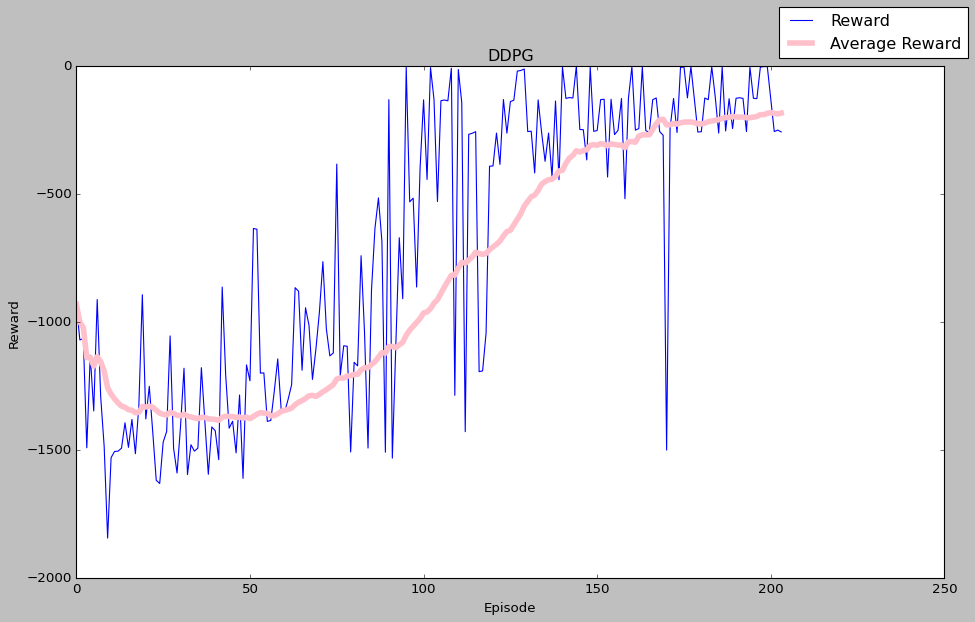

In [257]:
# Plotting training graph
with plt.style.context('classic'):
    plt.figure(figsize=(14, 8))
    plt.plot(ddpg_ep_reward_list)
    plt.plot(ddpg_avg_reward_list, linewidth=5, color=selected_color)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title("DDPG")
    plt.legend(['Reward', 'Average Reward'], loc='lower left', bbox_to_anchor=(0.8, 1))

    plt.savefig('save_network/DDPG/Train Learning Curve.png')

    plt.show()

## Improvements and Key Features

1. **Target Networks**:
   - Separate target networks are used for both the actor and the critic.
   - These target networks are updated softly (gradually) to improve stability during training.
   - The soft update mechanism averages the parameters of the target networks and the main networks.

2. **Experience Replay**:
   - The implementation utilizes a replay buffer.
   - Experience replay helps break correlations between consecutive samples.
   - By randomly sampling from the buffer, the agent learns from a diverse set of experiences.

3. **Exploration Noise**:
   - Ornstein-Uhlenbeck process is used for exploration noise.
   - This noise introduces temporally correlated exploration, encouraging smoother transitions between actions.
   - Exploration noise is crucial for discovering new strategies and avoiding local optima.

4. **Gradient Clipping**:
   - Although not explicitly implemented in this version, gradient clipping can be added for further stability.
   - Gradient clipping limits the magnitude of gradients during backpropagation, preventing large updates.

5. **Batch Normalization**:
   - Batch normalization is not used in this specific implementation.
   - However, it could be added to improve training stability by normalizing layer activations.

Overall, this DDPG implementation provides a solid foundation for solving continuous control tasks, such as the pendulum problem. By combining value-based and policy-based methods, DDPG is well-suited for environments with continuous action spaces. 🚀


---
---

# DDPG Model Improvement with Prioritized Replay Buffer and Ensemble Training

### Modified Critic Network:
- Increased network capacity (more neurons in hidden layers)
- Added BatchNormalization and Dropout layers for better generalization
### Modified Actor Network:
- Increased network capacity
- Added BatchNormalization layers
### ModifiedDDPGAgent:
- Incorporates Prioritized Experience Replay
- Uses OUActionNoise for exploration
- Implements soft updates for target networks
### Ensemble Training:
- Creates multiple DDPG agents
- Uses an ensemble approach for action selection

In [19]:
def mod_create_critic_network(env, model_name='CriticNetwork'):
    state_shape = env.observation_space.shape
    action_shape = env.action_space.shape

    # For state
    state_input = Input(shape=state_shape)
    state_out = Dense(64, activation="relu")(state_input)
    state_out = Dense(256, activation="relu")(state_out)

    # For action
    action_input = Input(shape=action_shape)
    action_out = Dense(64, activation="relu")(action_input)
    action_out = Dense(256, activation="relu")(action_out)

    concat = Concatenate()([state_out, action_out])

    output_layer = Dense(512, activation="relu")(concat)
    output_layer = BatchNormalization()(output_layer)
    output_layer = Dense(512, activation="relu")(output_layer)
    output_layer = Dropout(0.4)(output_layer)
    outputs = Dense(1)(output_layer)

    critic_model = Model(inputs=[state_input, action_input], outputs=outputs, name=model_name)
    return critic_model

## ---- ##

def mod_create_actor_network(env, model_name="ActorNetwork"):
    state_shape = env.observation_space.shape
    n_actions = env.action_space.shape[0]
    upper_bound = env.action_space.high[0]

    last_init = tf.keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)
    inputs = Input(shape=state_shape, name='state_input')
    outs = Dense(400, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(inputs)
    outs = BatchNormalization()(outs)
    outs = Dense(200, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(outs)
    outs = Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(outs)
    outputs = Dense(n_actions, activation="tanh", kernel_initializer=last_init)(outs)

    # Scale the output values to the env's requirements
    outputs = outputs * upper_bound

    actor_model = Model(inputs, outputs, name=model_name)
    return actor_model

In [20]:
class ModifiedDDPGAgent:
    def __init__(self, env, actor_main, critic_main, buffer_size, batch_size, gamma=0.99, tau=0.005, alpha=0.6, beta=0.4):
        self.env = env
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha
        self.beta = beta

        self.upper_bound = env.action_space.high[0]
        self.lower_bound = env.action_space.low[0]
        self.n_actions = env.action_space.shape[0]

        self.warmup = 50
        self.replace = 5
        self.trainstep = 0

        self.actor_main = actor_main
        self.critic_main = critic_main

        self.actor_target = tf.keras.models.clone_model(actor_main)
        self.critic_target = tf.keras.models.clone_model(critic_main)

        self.update_target_models(tau=1.0)
        self.replay_buffer = PrioritizedReplayBuffer(buffer_size, batch_size, alpha)
        self.noise = OUActionNoise(size=self.n_actions)

        self.a_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        self.c_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)

        # Compile the networks
        self.actor_main.compile(optimizer=self.a_optimizer, loss='mean')
        self.critic_main.compile(optimizer=self.c_optimizer, loss='mean_squared_error')
        self.actor_target.compile(optimizer=self.a_optimizer, loss='mean')
        self.critic_target.compile(optimizer=self.c_optimizer, loss='mean_squared_error')

    def update_target_models(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.actor_target.weights
        for i, weight in enumerate(self.actor_main.weights):
            weights.append(weight * tau + targets[i] * (1 - tau))
        self.actor_target.set_weights(weights)

        weights = []
        targets = self.critic_target.weights
        for i, weight in enumerate(self.critic_main.weights):
            weights.append(weight * tau + targets[i] * (1 - tau))
        self.critic_target.set_weights(weights)

    def act(self, state, evaluate=False):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        actions = self.actor_main(state)
        if not evaluate and self.trainstep > self.warmup:
            noise = self.noise()
            actions = tf.clip_by_value(actions + noise, self.lower_bound, self.upper_bound)
        return actions[0].numpy()

    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)

    def train(self):
        if len(self.replay_buffer) < self.replay_buffer.batch_size:
            return

        states, actions, rewards, next_states, dones, indices, weights = self.replay_buffer.sample(beta=self.beta)

        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            target_actions = self.actor_target(next_states)
            target_next_state_values = tf.squeeze(self.critic_target([next_states, target_actions]), 1)

            critic_value = tf.squeeze(self.critic_main([states, actions]), 1)
            target_values = rewards + self.gamma * target_next_state_values * (1 - dones)

            critic_loss = tf.keras.losses.MSE(target_values, critic_value)

            new_policy_actions = self.actor_main(states)
            actor_loss = -tf.reduce_mean(self.critic_main([states, new_policy_actions]))

        grads1 = tape1.gradient(actor_loss, self.actor_main.trainable_variables)
        grads2 = tape2.gradient(critic_loss, self.critic_main.trainable_variables)

        self.a_optimizer.apply_gradients(zip(grads1, self.actor_main.trainable_variables))
        self.c_optimizer.apply_gradients(zip(grads2, self.critic_main.trainable_variables))

        if self.trainstep % self.replace == 0:
            self.update_target_models()

        self.trainstep += 1

    def save_models(self, filepath):
        self.actor_main.save(filepath + "_actor_main.h5")
        self.actor_target.save(filepath + "_actor_target.h5")
        self.critic_main.save(filepath + "_critic_main.h5")
        self.critic_target.save(filepath + "_critic_target.h5")

In [260]:
# Create multiple agents
num_agents = 3
ddpg_agents = []
for _ in range(num_agents):
    mod_ddpg_actor = mod_create_actor_network(env)
    mod_ddpg_critic = mod_create_critic_network(env)
    mod_DDPG_agent = ModifiedDDPGAgent(env, mod_ddpg_actor, mod_ddpg_critic, buffer_size=100000, batch_size=batch_size, gamma=gamma, tau=tau, alpha=alpha, beta=beta)
    ddpg_agents.append(mod_DDPG_agent)

modified_ddpg_ep_reward_list = []
modified_ddpg_avg_reward_list = []

if not os.path.isdir('save_network/DDPG_modified'):
    os.makedirs('save_network/DDPG_modified')

# Ensemble

In [261]:
def ddpg_act_ensemble(state):
    actions = []
    for agent in ddpg_agents:
        action = agent.act(state)
        actions.append(action)
    final_action = np.max(actions, axis=0)
    return np.clip(final_action, -upper_bound, upper_bound)

In [262]:
%%time

saved_model_counter = 0

tf.keras.backend.clear_session()
K.clear_session()

txt = open("save_network/DDPG_modified/saved_networks.txt", "w")

for eps in range(EPOCHS):
    start_time = time.time()
    state = env.reset()
    episode_reward = 0
    done = False

    while not done:
        action = ddpg_act_ensemble(state)
        next_state, reward, done, _ = env.step(action)
        for agent in ddpg_agents:
            agent.remember(state, action, reward, next_state, done)
            agent.train()
        episode_reward += reward
        state = next_state

    modified_ddpg_ep_reward_list.append(episode_reward)
    avg_reward = np.mean(modified_ddpg_ep_reward_list[-50:])
    end_time = time.time()
    epoch_duration = end_time - start_time
    
    modified_ddpg_avg_reward_list.append(avg_reward)

    clear_output(wait=True)

    print(f"Episode * {eps} * Reward is ==> {episode_reward}, Time Taken: {epoch_duration:.2f}s")
    print(f"Episode * {eps} * Avg Reward is ==> {avg_reward}, Time Taken: {epoch_duration:.2f}s")
        
    if eps > 50 and avg_reward >= save_threshold:
        for idx, agent in enumerate(ddpg_agents):
            agent.save_models(f"save_network/DDPG_modified/modified_model_{saved_model_counter}_agent_{idx}")
        txt.write(f"Save {saved_model_counter} - Episode {eps}/{EPOCHS}, Average Reward: {avg_reward}\n")
        saved_model_counter += 1

print("Finished training!")
env.close()
txt.close()

Episode * 499 * Reward is ==> -245.2601619499914, Time Taken: 52.00s
Episode * 499 * Avg Reward is ==> -232.54245912509998, Time Taken: 52.00s
Finished training!
CPU times: total: 1h 15min 4s
Wall time: 7h 16min 37s


In [279]:
last_agent = ddpg_agents[-1]

# Save the last agent's models
last_agent.save_models(f"save_network/DDPG_modified/modified_model_last_agent")

print("Last model saved successfully.")

Last model saved successfully.


# Visualise Results

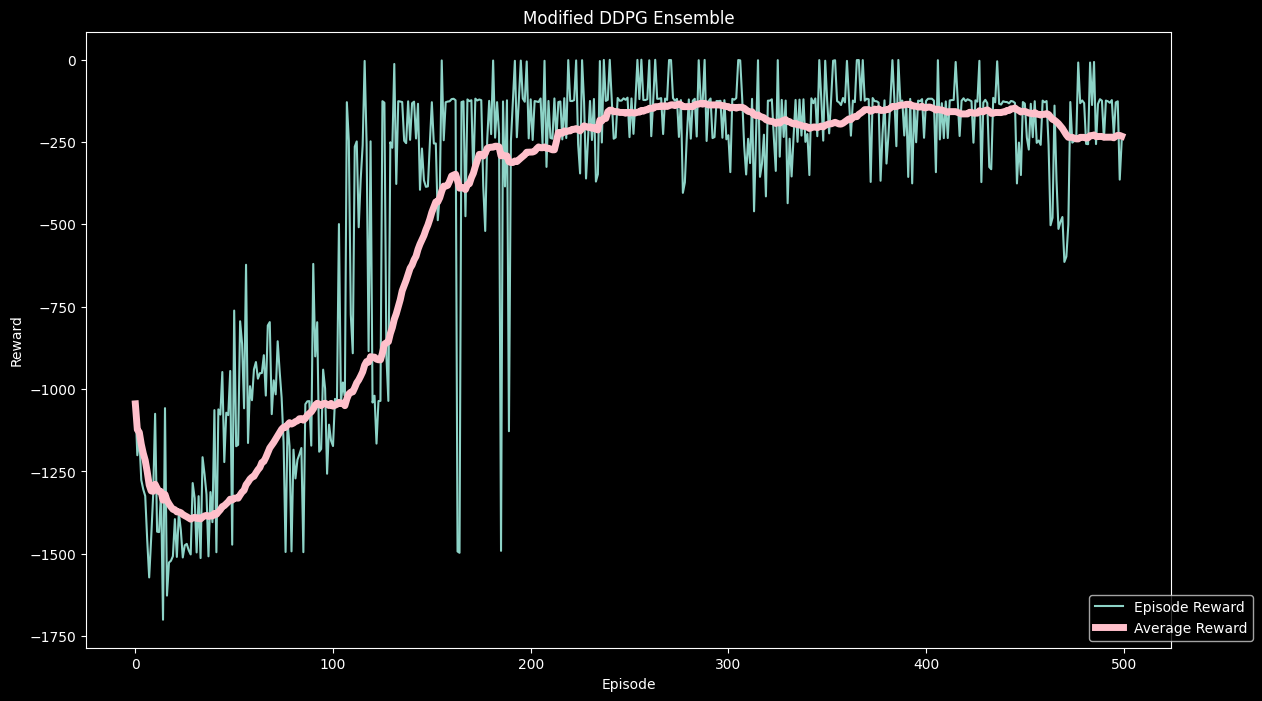

In [263]:
# Plotting training graph
with plt.style.context('dark_background'):
    plt.figure(figsize=(14, 8))
    plt.plot(modified_ddpg_ep_reward_list, label='Episode Reward')
    plt.plot(modified_ddpg_avg_reward_list, linewidth=5, color=selected_color, label='Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title("Modified DDPG Ensemble")
    plt.legend(loc='lower center', bbox_to_anchor=(1, 0))

    plt.savefig('save_network/DDPG_modified/Train_Learning_Curve.png')
    plt.show()

---
---

Episode: 50, Reward: -247.23297434422827
Average Reward over 50 episodes: -160.58046733444758


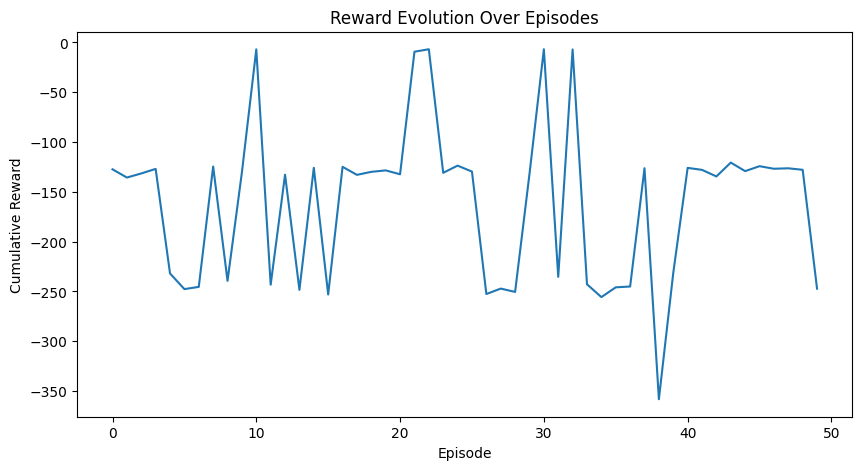

In [23]:
tf.keras.backend.clear_session()
K.clear_session()


test_mod_actor = mod_create_actor_network(env)
test_mod_critic = mod_create_critic_network(env)

# Create the DDPG agent with the actor and critic models
testing_ddpg_agent = ModifiedDDPGAgent(env, test_mod_actor, test_mod_critic, buffer_size=100000, batch_size=64, gamma=0.99, tau=0.005, alpha=0.6, beta=0.4)

# Load the weights into the main actor and critic models of the agent
testing_ddpg_agent.actor_main.load_weights('save_network/DDPG_modified/modified_model_last_agent_actor_main.h5')
testing_ddpg_agent.critic_main.load_weights('save_network/DDPG_modified/modified_model_last_agent_critic_main.h5')

clear_output(wait=True)

# Run the test
test_agent(env, testing_ddpg_agent, folder='DDPG_modified', episodes=50, video_dir='./video', custom_name='ddpg_pendulum_episode')

## These enhancements aim to improve the agent's performance in the continuous control task of balancing the pendulum.

---
---

## Twin Delayed Deep Deterministic Policy Gradient (TD3) Reinforcement Learning Model

The Twin Delayed Deep Deterministic Policy Gradient (TD3) algorithm represents a significant improvement over its predecessor, DDPG, by addressing some of its limitations and enhancing stability and performance. TD3 incorporates several innovative techniques to mitigate the overestimation bias inherent in Q-learning methods, thereby improving the reliability of policy learning in continuous action spaces.

### Actor Network
- **Description**: Similar to DDPG, the Actor network in TD3 selects actions based on the current state of the environment. It implements a deterministic policy, directly mapping states to actions without sampling from a probability distribution. The Actor's output is a deterministic action aiming to maximize the expected return.
- **Role in TD3**: The Actor network balances exploration and exploitation, seeking actions that yield high returns while exploring new strategies through added noise during training.

### Critic Networks
- **Description**: Unlike DDPG, TD3 introduces twin Critic networks. These networks estimate the Q-value (expected return) of taking certain actions in given states under the current policy. By maintaining two Critic networks, TD3 reduces overestimation bias by considering the minimum Q-value estimate during policy updates.
- **Role in TD3**: The twin Critic networks stabilize learning by providing conservative estimates of action values, guiding the Actor network toward promising actions.

### Target Networks and Delayed Updates
- **Description**: TD3 retains target networks from DDPG but enhances stability. Target networks are slower-moving copies of the Actor and Critic networks, updated gradually using soft updates. TD3 also delays policy updates relative to Q-function updates for accurate Q-value estimations before adjusting the policy.
- **Role in TD3**: Delayed updates and target networks contribute to stability, mitigating drastic policy changes that could disrupt learning.

### Action Noise Regularization
- **Description**: To prevent exploitation of overestimated Q-values, TD3 introduces action noise regularization. During policy updates, noise is added to actions selected by the target Actor network. This encourages smoother policy updates and prevents excessive reliance on potentially overestimated Q-values.
- **Role in TD3**: Action noise regularization maintains policy robustness against inaccuracies in Q-value estimates, ensuring adaptability to new information.


In [6]:
def create_td3_critic_network(env, model_name='TD3CriticNetwork'):
    state_shape = env.observation_space.shape
    action_shape = env.action_space.shape

    # For state
    state_input = Input(shape=state_shape)
    state_out = Dense(64, activation="relu")(state_input)
    state_out = Dense(128, activation="relu")(state_out)

    # For action
    action_input = Input(shape=action_shape)
    action_out = Dense(64, activation="relu")(action_input)
    action_out = Dense(128, activation="relu")(action_out)

    concat = Concatenate()([state_out, action_out])

    output_layer = Dense(128, activation="relu")(concat)
    output_layer = Dense(128, activation="relu")(output_layer)
    outputs = Dense(1)(output_layer)

    critic_model = Model(inputs=[state_input, action_input], outputs=outputs, name=model_name)
    return critic_model

## ---- ##

def create_td3_actor_network(env, model_name="TD3ActorNetwork"):
    state_shape = env.observation_space.shape
    n_actions = env.action_space.shape[0]
    upper_bound = env.action_space.high[0]

    last_init = tf.keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)
    inputs = Input(shape=state_shape, name='state_input')
    outs = Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(inputs)
    outs = Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(outs)
    outs = Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(outs)
    outputs = Dense(n_actions, activation="tanh", kernel_initializer=last_init)(outs)

    # Scale the output values to the env's requirements
    outputs = outputs * upper_bound

    actor_model = Model(inputs, outputs, name=model_name)
    return actor_model

In [7]:
class TD3Agent:
    def __init__(self, env, actor_main, critic_main1, critic_main2, buffer_size, batch_size, gamma=0.99, tau=0.005):
        self.env = env
        self.gamma = gamma
        self.tau = tau
        self.upper_bound = env.action_space.high[0]
        self.lower_bound = env.action_space.low[0]
        self.n_actions = env.action_space.shape[0]
        self.warmup = 200
        self.trainstep = 0
        self.actor_update_steps = 5

        self.actor_main = actor_main
        self.critic_main1 = critic_main1
        self.critic_main2 = critic_main2

        self.actor_target = tf.keras.models.clone_model(actor_main)
        self.critic_target1 = tf.keras.models.clone_model(critic_main1)
        self.critic_target2 = tf.keras.models.clone_model(critic_main2)

        self.update_target_models(tau)
        self.replay_buffer = SimpleReplayBuffer(buffer_size, batch_size)
        self.noise = OUActionNoise(size=self.n_actions)

        self.a_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        self.c_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)

        self.actor_main.compile(optimizer= self.a_optimizer, loss='mean')
        self.critic_main1.compile(optimizer=self.c_optimizer,loss='mean_squared_error')
        self.critic_main2.compile(optimizer=self.c_optimizer,loss='mean_squared_error')

        self.actor_target.compile(optimizer= self.a_optimizer,loss='mean')
        self.critic_target1.compile(optimizer=self.c_optimizer,loss='mean_squared_error')
        self.critic_target2.compile(optimizer=self.c_optimizer,loss='mean_squared_error')

    def update_target_models(self, tau=None):
        if tau is None:
            tau = self.tau

        # Update actor target
        weights = []
        targets = self.actor_target.weights
        for i, weight in enumerate(self.actor_main.weights):
            weights.append(weight * tau + targets[i] * (1 - tau))
        self.actor_target.set_weights(weights)

        # Update critic target 1
        weights = []
        targets = self.critic_target1.weights
        for i, weight in enumerate(self.critic_main1.weights):
            weights.append(weight * tau + targets[i] * (1 - tau))
        self.critic_target1.set_weights(weights)

        # Update critic target 2
        weights = []
        targets = self.critic_target2.weights
        for i, weight in enumerate(self.critic_main2.weights):
            weights.append(weight * tau + targets[i] * (1 - tau))
        self.critic_target2.set_weights(weights)

    def act(self, state, evaluate=False):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        actions = self.actor_main(state)
        if not evaluate and self.trainstep > self.warmup:
            noise = self.noise()
            actions = tf.clip_by_value(actions + noise, self.lower_bound, self.upper_bound)
        return actions[0].numpy()

    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)

    def train(self):
        if len(self.replay_buffer) < self.replay_buffer.batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample()

        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            target_actions = self.actor_target(next_states)
            target_actions += tf.clip_by_value(tf.random.normal(shape=target_actions.shape, mean=0.0, stddev=0.2), -0.5, 0.5)
            target_actions = self.upper_bound * (tf.clip_by_value(target_actions, self.lower_bound, self.upper_bound))

            target_next_state_values1 = tf.squeeze(self.critic_target1([next_states, target_actions]), 1)
            target_next_state_values2 = tf.squeeze(self.critic_target2([next_states, target_actions]), 1)
            target_next_state_values = tf.math.minimum(target_next_state_values1, target_next_state_values2)

            target_values = rewards + self.gamma * target_next_state_values * (1 - dones)

            critic_value1 = tf.squeeze(self.critic_main1([states, actions]), 1)
            critic_value2 = tf.squeeze(self.critic_main2([states, actions]), 1)

            critic_loss1 = tf.keras.losses.MSE(target_values, critic_value1)
            critic_loss2 = tf.keras.losses.MSE(target_values, critic_value2)

        grads1 = tape1.gradient(critic_loss1, self.critic_main1.trainable_variables)
        grads2 = tape2.gradient(critic_loss2, self.critic_main2.trainable_variables)

        self.c_optimizer.apply_gradients(zip(grads1, self.critic_main1.trainable_variables))
        self.c_optimizer.apply_gradients(zip(grads2, self.critic_main2.trainable_variables))

        if self.trainstep % self.actor_update_steps == 0:
            with tf.GradientTape() as tape3:
                new_policy_actions = self.actor_main(states)
                actor_loss = -tf.reduce_mean(self.critic_main1([states, new_policy_actions]))

            grads3 = tape3.gradient(actor_loss, self.actor_main.trainable_variables)
            self.a_optimizer.apply_gradients(zip(grads3, self.actor_main.trainable_variables))

        if self.trainstep % self.actor_update_steps == 0:
            self.update_target_models(0.05)

        self.trainstep += 1

    def save_models(self, filepath):
        self.actor_main.save(filepath + "_actor_main.h5")
        self.actor_target.save(filepath + "_actor_target.h5")
        self.critic_main1.save(filepath + "_critic_main1.h5")
        self.critic_main2.save(filepath + "_critic_main2.h5")
        self.critic_target1.save(filepath + "_critic_target1.h5")
        self.critic_target2.save(filepath + "_critic_target2.h5")

In [13]:
# Model and Network Creations

td3_actor = create_td3_actor_network(env)
td3_critc1 = create_td3_critic_network(env)
td3_critc2 = create_td3_critic_network(env)

td3_agent = TD3Agent(env, actor_main=td3_actor, critic_main1=td3_critc1, critic_main2=td3_critc2, buffer_size=100000, batch_size=batch_size, gamma=gamma, tau=tau)

td3_ep_reward_list = []
td3_avg_reward_list = []

if not os.path.isdir('save_network/TD3'):
        os.makedirs('save_network/TD3')

In [14]:
%%time

saved_model_counter = 0

tf.keras.backend.clear_session()
K.clear_session()

txt = open("save_network/TD3/saved_networks.txt", "w")

for eps in range(200):
    start_time = time.time()
    state = env.reset()
    episode_reward = 0
    done = False

    while not done:
        # env.render()  #!Debug

        action = td3_agent.act(state)
        next_state, reward, done, _ = env.step(action)
        td3_agent.remember(state, action, reward, next_state, done)
        td3_agent.train()
        episode_reward += reward
        state = next_state

    td3_ep_reward_list.append(episode_reward)
    avg_reward = np.mean(td3_ep_reward_list[-50:])
    end_time = time.time()
    epoch_duration = end_time - start_time
    
    td3_avg_reward_list.append(avg_reward)

    clear_output(wait=True)

    print(f"Episode * {eps} * Reward is ==> {episode_reward}, Time Taken: {epoch_duration:.2f}s")
    print(f"Episode * {eps} * Avg Reward is ==> {avg_reward}, Time Taken: {epoch_duration:.2f}s")
        
    if eps > 50 and avg_reward >= save_threshold:
        td3_agent.save_models(f"save_network/TD3/model_{saved_model_counter}")
        txt.write(f"Save {saved_model_counter} - Episode {eps}/{EPOCHS}, Score: {episode_reward}, Avg Reward: {avg_reward}\n")
        saved_model_counter += 1

txt.close()

print("Finished training!")
env.close()

Episode * 199 * Reward is ==> -982.9951367027614, Time Taken: 11.40s
Episode * 199 * Avg Reward is ==> -1286.8474582676236, Time Taken: 11.40s
Finished training!
CPU times: total: 2min 23s
Wall time: 43min 13s


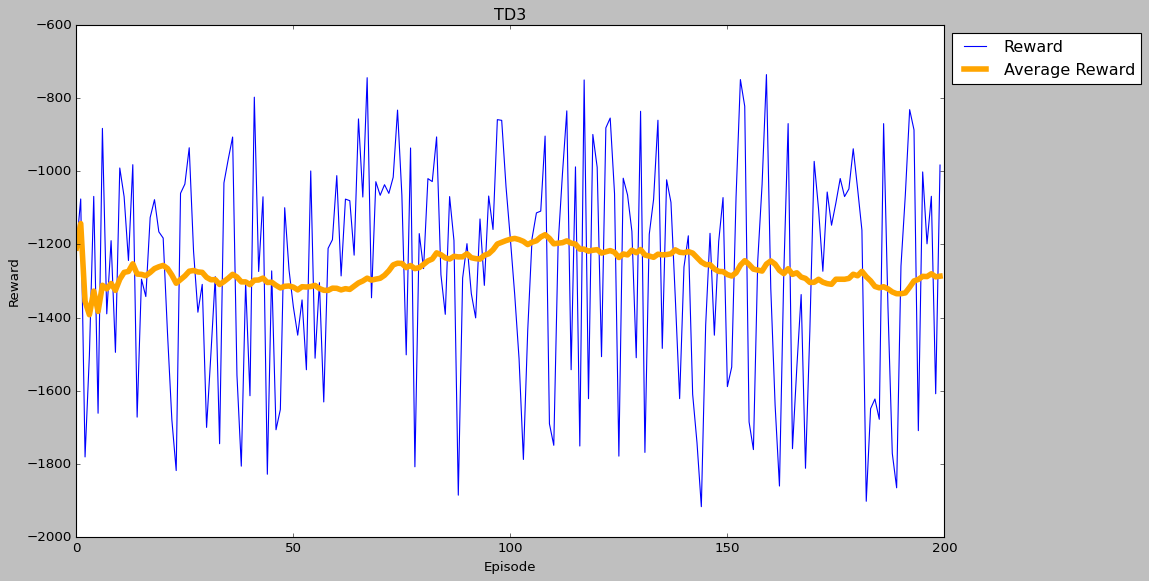

In [15]:
# Plotting training graph
with plt.style.context('classic'):
    plt.figure(figsize=(14, 8))
    plt.plot(td3_ep_reward_list)
    plt.plot(td3_avg_reward_list, linewidth=5, color=selected_color)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title("TD3")

    plt.legend(['Reward', 'Average Reward'], loc='upper left', bbox_to_anchor=(1, 1))

    plt.savefig('save_network/TD3/Train Learning Curve.png')

    plt.show()

---

In [38]:
def mod_create_td3_critic_network(env, model_name='TD3CriticNetwork'):
    state_shape = env.observation_space.shape
    action_shape = env.action_space.shape

    state_input = Input(shape=state_shape)
    action_input = Input(shape=action_shape)

    concat = Concatenate()([state_input, action_input])

    output_layer = Dense(512, activation="relu")(concat)
    output_layer = Dropout(0.4)(output_layer)
    output_layer = Dense(512, activation="relu")(output_layer)
    output_layer = BatchNormalization()(output_layer)
    outputs = Dense(1)(output_layer)

    critic_model = Model(inputs=[state_input, action_input], outputs=outputs, name=model_name)
    return critic_model

def mod_create_td3_actor_network(env, model_name="TD3ActorNetwork"):
    state_shape = env.observation_space.shape
    n_actions = env.action_space.shape[0]
    upper_bound = env.action_space.high[0]

    last_init = tf.keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)
    inputs = Input(shape=state_shape, name='state_input')
    outs = Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(inputs)
    outs = BatchNormalization()(outs)
    outs = Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(outs)
    outputs = Dense(n_actions, activation="tanh", kernel_initializer=last_init)(outs)

    outputs = outputs * upper_bound

    actor_model = Model(inputs, outputs, name=model_name)
    return actor_model

In [39]:
class ModTD3Agent:
    def __init__(self, env, actor_main, critic_main1, critic_main2, buffer_size, batch_size, gamma=0.99, tau=0.005):
        self.env = env
        self.gamma = gamma
        self.tau = tau

        self.upper_bound = env.action_space.high[0]
        self.lower_bound = env.action_space.low[0]
        self.n_actions = env.action_space.shape[0]

        self.warmup = 50
        self.trainstep = 0
        self.actor_update_steps = 2  # Update actor every two critic updates

        self.actor_main = actor_main
        self.critic_main1 = critic_main1
        self.critic_main2 = critic_main2

        self.actor_target = tf.keras.models.clone_model(actor_main)
        self.critic_target1 = tf.keras.models.clone_model(critic_main1)
        self.critic_target2 = tf.keras.models.clone_model(critic_main2)

        self.update_target_models(tau)
        self.replay_buffer = PrioritizedReplayBuffer(buffer_size, batch_size)
        self.noise = OUActionNoise(size=self.n_actions)

        self.a_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        self.c_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

        self.actor_main.compile(optimizer=self.a_optimizer, loss='mean')
        self.critic_main1.compile(optimizer=self.c_optimizer, loss=tf.keras.losses.Huber())
        self.critic_main2.compile(optimizer=self.c_optimizer, loss=tf.keras.losses.Huber())

        self.actor_target.compile(optimizer=self.a_optimizer, loss='mean')
        self.critic_target1.compile(optimizer=self.c_optimizer, loss=tf.keras.losses.Huber())
        self.critic_target2.compile(optimizer=self.c_optimizer, loss=tf.keras.losses.Huber())

    def update_target_models(self, tau=None):
        if tau is None:
            tau = self.tau

        for target_model, model in zip([self.actor_target, self.critic_target1, self.critic_target2],
                                       [self.actor_main, self.critic_main1, self.critic_main2]):
            new_weights = model.get_weights()
            target_weights = target_model.get_weights()
            updated_weights = [tau * nw + (1 - tau) * tw for nw, tw in zip(new_weights, target_weights)]
            target_model.set_weights(updated_weights)

    def act(self, state, evaluate=False):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        actions = self.actor_main(state)
        if not evaluate and self.trainstep > self.warmup:
            noise = self.noise()
            actions = tf.clip_by_value(actions + noise, self.lower_bound, self.upper_bound)
        return actions[0].numpy()

    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)

    def train(self):
        if len(self.replay_buffer) < self.replay_buffer.batch_size:
            return

        states, actions, rewards, next_states, dones, indices, weights = self.replay_buffer.sample(beta=0.4)

        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            target_actions = self.actor_target(next_states)
            noise = tf.clip_by_value(tf.random.normal(shape=target_actions.shape, stddev=0.2), -0.2, 0.2)
            target_actions = tf.clip_by_value(target_actions + noise, self.lower_bound, self.upper_bound)

            target_next_state_values1 = tf.squeeze(self.critic_target1([next_states, target_actions]), 1)
            target_next_state_values2 = tf.squeeze(self.critic_target2([next_states, target_actions]), 1)
            target_next_state_values = tf.minimum(target_next_state_values1, target_next_state_values2)

            target_values = rewards + self.gamma * target_next_state_values * (1 - dones)

            critic_value1 = tf.squeeze(self.critic_main1([states, actions]), 1)
            critic_value2 = tf.squeeze(self.critic_main2([states, actions]), 1)

            critic_loss1 = tf.reduce_mean(weights * tf.square(target_values - critic_value1))
            critic_loss2 = tf.reduce_mean(weights * tf.square(target_values - critic_value2))

        grads1 = tape1.gradient(critic_loss1, self.critic_main1.trainable_variables)
        grads2 = tape2.gradient(critic_loss2, self.critic_main2.trainable_variables)

        self.c_optimizer.apply_gradients(zip(grads1, self.critic_main1.trainable_variables))
        self.c_optimizer.apply_gradients(zip(grads2, self.critic_main2.trainable_variables))

        if self.trainstep % self.actor_update_steps == 0:
            with tf.GradientTape() as tape3:
                new_policy_actions = self.actor_main(states)
                actor_loss = -tf.reduce_mean(self.critic_main1([states, new_policy_actions]))

            grads3 = tape3.gradient(actor_loss, self.actor_main.trainable_variables)
            self.a_optimizer.apply_gradients(zip(grads3, self.actor_main.trainable_variables))

        if self.trainstep % self.actor_update_steps == 0:
            self.update_target_models()

        self.trainstep += 1

    def save_models(self, filepath):
        self.actor_main.save(filepath + "_actor_main.h5")
        self.actor_target.save(filepath + "_actor_target.h5")
        self.critic_main1.save(filepath + "_critic_main1.h5")
        self.critic_main2.save(filepath + "_critic_main2.h5")
        self.critic_target1.save(filepath + "_critic_target1.h5")
        self.critic_target2.save(filepath + "_critic_target2.h5")

In [272]:
# Create multiple agents
num_agents = 2
td3_agents = []

for _ in range(num_agents):
    mod_td3_actor = mod_create_td3_actor_network(env)
    mod_td3_critc1 = mod_create_td3_critic_network(env)
    mod_td3_critc2 = mod_create_td3_critic_network(env)

    mod_td3_agent = ModTD3Agent(env, actor_main=mod_td3_actor, critic_main1=mod_td3_critc1, critic_main2=mod_td3_critc2, buffer_size=100000, batch_size=batch_size, gamma=gamma, tau=tau)

    td3_agents.append(mod_td3_agent)

mod_td3_ep_reward_list = []
mod_td3_avg_reward_list = []

if not os.path.isdir('save_network/mod_TD3'):
        os.makedirs('save_network/mod_TD3')

In [273]:
def td3_act_ensemble(state):
    actions = []
    for agent in td3_agents:
        action = agent.act(state)
        actions.append(action)
    final_action = np.max(actions, axis=0)
    return np.clip(final_action, -upper_bound, upper_bound)

# Save our best models

In [274]:
%%time

saved_model_counter = 0

tf.keras.backend.clear_session()
K.clear_session()

txt = open("save_network/mod_TD3/saved_networks.txt", "w")

for eps in range(EPOCHS):
    start_time = time.time()
    state = env.reset()
    episode_reward = 0
    done = False

    while not done:
        action = td3_act_ensemble(state)
        next_state, reward, done, _ = env.step(action)
        for agent in td3_agents:
            agent.remember(state, action, reward, next_state, done)
            agent.train()
        episode_reward += reward
        state = next_state

    mod_td3_ep_reward_list.append(episode_reward)
    avg_reward = np.mean(mod_td3_ep_reward_list[-50:])
    end_time = time.time()
    epoch_duration = end_time - start_time
    
    mod_td3_avg_reward_list.append(avg_reward)

    clear_output(wait=True)

    print(f"Episode * {eps} * Reward is ==> {episode_reward}, Time Taken: {epoch_duration:.2f}s")
    print(f"Episode * {eps} * Avg Reward is ==> {avg_reward}, Time Taken: {epoch_duration:.2f}s")
        
    if eps > 50 and avg_reward >= save_threshold:
        for idx, agent in enumerate(td3_agents):
            agent.save_models(f"save_network/mod_TD3/modified_model_{saved_model_counter}_agent_{idx}")
        txt.write(f"Save {saved_model_counter} - Episode {eps}/{EPOCHS}, Average Reward: {avg_reward}\n")
        saved_model_counter += 1

print("Finished training!")

last_agent = td3_agents[-1]

# Save the last agent's models
last_agent.save_models(f"save_network/mod_TD3/modified_model_last_agent.h5")

print("Last model saved successfully.")

env.close()
txt.close()

Episode * 405 * Reward is ==> -261.91626307107816, Time Taken: 46.54s
Episode * 405 * Avg Reward is ==> -272.9375990097842, Time Taken: 46.54s
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Oak_Khant_Soe\anaconda3\envs\gpu_env\lib\site-packages\IPython\core\magics\execution.py", line 1340, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 15, in <module>
  File "C:\Users\Oak_Khant_Soe\AppData\Local\Temp\ipykernel_3452\4047400977.py", line 4, in td3_act_ensemble
    action = agent.act(state)
  File "C:\Users\Oak_Khant_Soe\AppData\Local\Temp\ipykernel_3452\2291872737.py", line 55, in act
    return actions[0].numpy()
  File "c:\Users\Oak_Khant_Soe\anaconda3\envs\gpu_env\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "c:\Users\Oak_Khant_Soe\anaconda3\envs\gpu_env\lib\site-packages\tensorflow\python\util\dispatch.py", line 1176, in op_dispatch_handler
    return dispatch_target(*args, **kwargs)
  File "c:\Users\Oak_Khant_Soe\anaconda3\envs\gpu_env\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1096, in _slice_helper


In [276]:
last_agent = td3_agents[-2]

# Save the last agent's models
last_agent.save_models(f"save_network/mod_TD3/modified_model_last_agent.h5")

print("Last model saved successfully.")

Last model saved successfully.


# Visualise Results

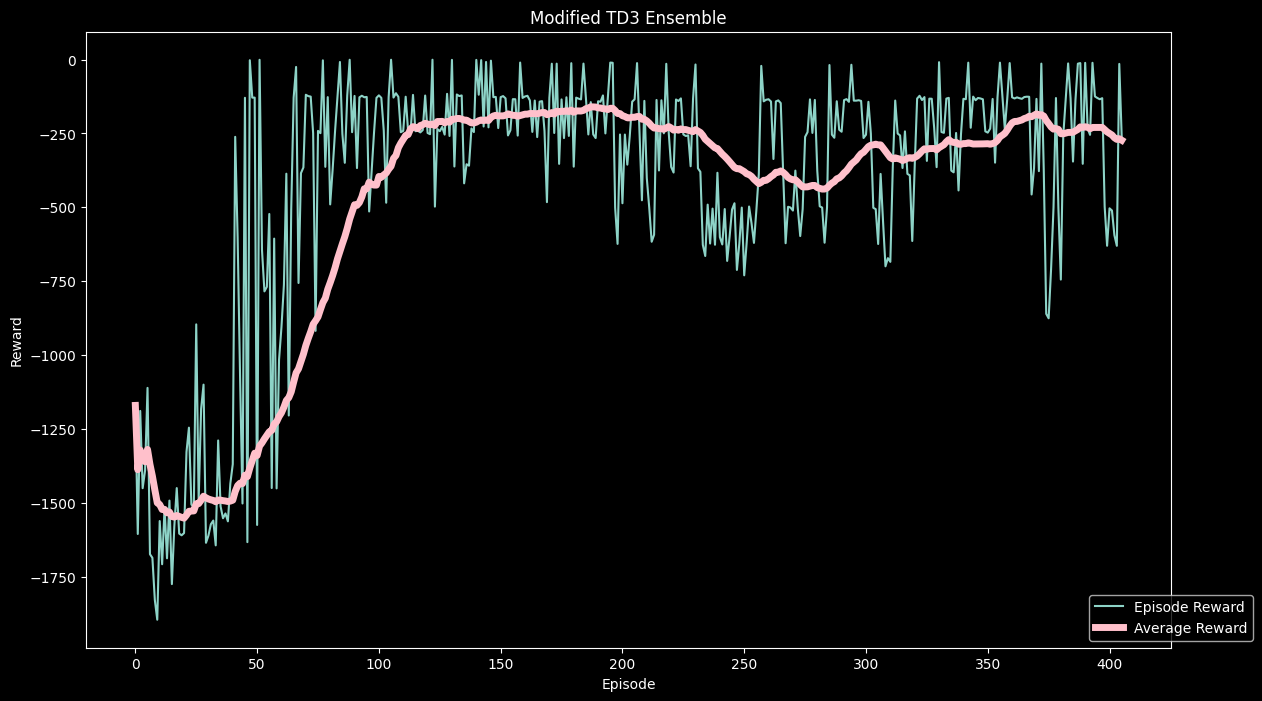

In [277]:
# Plotting training graph
with plt.style.context('dark_background'):
    plt.figure(figsize=(14, 8))
    plt.plot(mod_td3_ep_reward_list, label='Episode Reward')
    plt.plot(mod_td3_avg_reward_list, linewidth=5, color=selected_color, label='Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title("Modified TD3 Ensemble")
    plt.legend(loc='lower center', bbox_to_anchor=(1, 0))

    plt.savefig('save_network/mod_TD3/Train_Learning_Curve.png')
    plt.show()

Episode: 20, Reward: -133.13185572804085
Average Reward over 20 episodes: -156.86709183404463


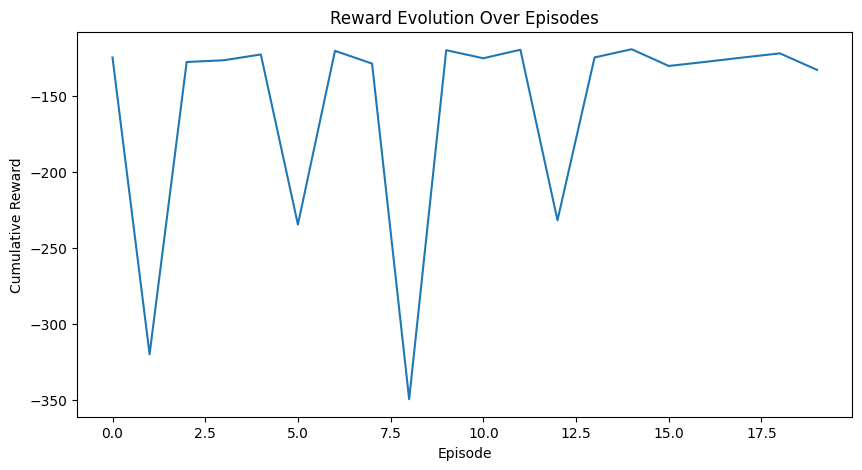

In [41]:
tf.keras.backend.clear_session()

# Create actor and critic networks
mod_td3_actor_model = mod_create_td3_actor_network(env)
mod_td3_critic_model1 = mod_create_td3_critic_network(env)
mod_td3_critic_model2 = mod_create_td3_critic_network(env)

# Initialize the TD3 agent
testing_td3_agent = ModTD3Agent(env, actor_main=mod_td3_actor_model, critic_main1=mod_td3_critic_model1, critic_main2=mod_td3_critic_model2, buffer_size=100000, batch_size=64, gamma=0.99, tau=0.005)

# Load the weights into the correct attributes
testing_td3_agent.actor_main.load_weights('save_network/mod_TD3/modified_model_last_agent_actor_main.h5')
testing_td3_agent.critic_main1.load_weights('save_network/mod_TD3/modified_model_last_agent_critic_main1.h5')
testing_td3_agent.critic_main2.load_weights('save_network/mod_TD3/modified_model_last_agent_critic_main2.h5')
testing_td3_agent.actor_target.load_weights('save_network/mod_TD3/modified_model_last_agent_actor_target.h5')
testing_td3_agent.critic_target1.load_weights('save_network/mod_TD3/modified_model_last_agent_critic_target1.h5')
testing_td3_agent.critic_target2.load_weights('save_network/mod_TD3/modified_model_last_agent_critic_target2.h5')

# Run the test
test_agent(env, testing_td3_agent, folder='mod_TD3', episodes=20, video_dir='./video', custom_name='td3_pendulum_episode')

## Summary of Modifications and Additions

1. **Critic Network with Dropout and Batch Normalization**:
   - The critic network now includes dropout layers to prevent overfitting.
   - Batch normalization layers are added to stabilize and speed up training.

2. **Actor Network with Leaky ReLU Activation and Batch Normalization**:
   - The actor network has been updated to use LeakyReLU activations and batch normalization, which can help with training stability and convergence.

3. **Modified TD3 Agent Class**:
   - The agent now uses a prioritized replay buffer.
   - Learning rates for the critic networks have been increased.
   - Huber loss is used for the critics to potentially handle outliers better.

4. **Ensemble of Agents**:
   - Creation of multiple TD3 agents to form an ensemble.
   - Actions are aggregated by taking the maximum across the agents.

5. **Training Loop for Ensemble**:
   - The training loop now includes the ensemble of agents, with each agent acting and training individually.

### Recommendations

- **Ensure Consistency in Initializations**:
  - Make sure all layers in actor and critic networks have consistent initializations (e.g., using a specific kernel initializer).

- **Logging and Debugging**:
  - Consider adding detailed logging within the training loop to monitor losses and gradient values for debugging.

- **Hyperparameter Tuning**:
  - Experiment with different values for hyperparameters (e.g., actor_update_steps, warmup, tau, learning rates) to optimize performance.

- **Environment Reset Handling**:
  - Properly handle environment resets to avoid issues during continuous training.

- **Periodic Model Saving**:
  - Save models periodically or based on performance thresholds to prevent data loss in case of interruptions.
